# import

In [1]:
import sys
sys.path.append('../')
from my_library.library import *
from hyperopt import hp, tpe, Trials, fmin,STATUS_OK
from my_library.funcs import *
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt



# path win

In [2]:
path_tpx = '/Users/Owner/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/Owner/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/Owner/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/Owner/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'
path_tpx_sim = '/Users/Owner/Desktop/StockPriceData/TOPIX/TOPIX_20211208.csv'
path_daw_sim = '/Users/Owner/Desktop/StockPriceData/DAW/DAW_20211208.csv'
save_pickle_path = '/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles'

# funcs

In [3]:


def get_gyosyu_df(path_gyosyu = '/Users/Owner/Desktop/StockPriceData/Gyosyu/'):
    FILE = glob.glob(path_gyosyu+'*.csv')
    df_dict = {}
    for file in FILE:
        name = file.replace(path_gyosyu,'')[:-4]
        df = pd.read_csv(file)
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:'open',\
                                    df.columns[6]:'high',df.columns[7]:'low',df.columns[8]:'close',\
                                        df.columns[9]:'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)
        df_dict[name] = df

    return df_dict,FILE

def return_corr(df):
    x = df['daw_close'].values
    y = df['close'].values
    corr = np.corrcoef(x,y)
    return corr

def split_df(df,start_year,end_year,start_month=1,end_month=12):
    df = df[df.index.year<=end_year]
    df = df[df.index.year>=start_year]
    df = df[df.index.month<=end_month]
    if start_month>0:
        df = df[df.index.month>=start_month]
    return df

def make_value_list(lx,start_year,end_year,path_tpx,path_daw,alpha=0.34,width=20,stride=10,start_month=1,end_month=12):

    lc_dummy = LearnClustering(width=width)
    df_con = lc_dummy.make_df_con(path_tpx,path_daw)
    
    df_con = split_df(df_con,start_year,end_year,start_month,end_month)
    
    x_,z_ = lc_dummy.make_x_data(df_con['close'],stride=stride,test_rate=1.0,width=width)
    length = len(z_)
    value_list = []

    for i in range(length):
        for strategy in ['normal','reverse']:
            try:
                xl = XGBSimulation2(lx,alpha=alpha)
                xl.simulate(path_tpx,path_daw,strategy=strategy,is_validate=True,start_year=start_year,end_year=end_year,df_=z_[i])
                
                trade_log =  xl.trade_log
                total_profit = trade_log['total_profit'].values[0]
                stock_wave = z_[i]
                vt = ValueTable(strategy,alpha,total_profit,trade_log,stock_wave)
                value_list.append(vt)
                
            except Exception as e:
                print(e)
                continue

    return value_list

def make_value_lx_dict(width=20,stride=5,path_=path_tpx):
    lx_dict = {}
    value_dict = {}


    lx_dummy = LearnXGB(num_class=3)
    x_train,y_train,_,_= lx_dummy.make_xgb_data(path_,path_daw,test_rate=1.0)
    _,_ ,x_test,y_test = lx_dummy.make_xgb_data(path_,path_daw,test_rate=0.9)

    # value_list 学習させるために 1Q ずらした lx が必要
    limit_year = 2015
    x_train_ = split_df(x_train,2015,limit_year)
    y_train_ = y_train[:len(x_train_)]
    lx = LearnXGB(num_class=3)
    lx.learn_xgb2(x_train_,y_train_,x_test,y_test,verbose=False)
    lx_dict[str(limit_year)] = lx

    for year in range(limit_year+1,2022):
        start_year = 2015
        end_year = year

        x_train_ = split_df(x_train,start_year,end_year)
        y_train_ = y_train[:len(x_train_)]
        
        
        lx = LearnXGB(num_class=3)
        lx.learn_xgb2(x_train_,y_train_,x_test,y_test,verbose=False)

        last_key = next(reversed(lx_dict),None)
        value_list = make_value_list(lx_dict[last_key],year,year,path_,path_daw,width=width,stride=stride)
        value_dict[str(year)] = value_list
        
        lx_dict[str(year)] = lx
    
    return value_dict,lx_dict
        
def return_clx(Value_list):
    Value_good = sorted(Value_list,key=lambda x :x[2],reverse=True)
    Value_bad = sorted(Value_list,key=lambda x :x[2],reverse=False)
    ng = []
    rg = []
    nb = []
    rb = []
    
    # 1sigam = 外れ値 として処理する
    prf_list=[]
    for vg in Value_good:
        total_profit = vg.total_profit
        prf_list.append(total_profit)      
    prf_array = np.array(prf_list)
    st_prf = standarize(prf_array)

    for idx,v in enumerate(Value_good):
        if v.total_profit<=0:break
        # if np.abs(st_prf[idx]) >=1:continue    

        df = v.stock_wave
        strategy = v.strategy
        # print(df)
        # break
        if strategy=="normal":
            ng.append(standarize(df))
        else:
            rg.append(standarize(df))

    prf_list=[]
    for vb in Value_bad:
        total_profit = vb.total_profit
        prf_list.append(total_profit)      
    prf_array = np.array(prf_list)
    st_prf = standarize(prf_array)

    for v in Value_bad:
        if v.total_profit>=0 :break
        # if np.abs(st_prf[idx]) >=1:continue  
        
        df = v.stock_wave
        strategy = v.strategy

        if strategy=="normal":
            nb.append(standarize(df))
        else:
            rb.append(standarize(df))

    x_ng = make_easy_x(ng)
    x_nb = make_easy_x(nb)
    x_rg = make_easy_x(rg)
    x_rb = make_easy_x(rb)
    return x_ng,x_nb,x_rg,x_rb

def return_ffs(lx,x_ng,x_nb,x_rg,x_rb,FFT_simulation,width=20,stride=10,window_type='none',is_high_pass=False,is_low_pass=True,cut_off=3):


    log_dict = {}
    cs_dict = {}
    ffs_dict = {}
    

    random_state=0

    alpha = 0.33
    n_cluster = 1
        
    Fstrategies = []
    Wstrategies = []
    Cstrategies = []
    F_list = []
    Phases = []
    lc_rg = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rg.learn_clustering3(x_rg,width=width)
    lc_rb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rb.learn_clustering3(x_rb,width=width)
    lc_ng = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_ng.learn_clustering3(x_ng,width=width)
    lc_nb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_nb.learn_clustering3(x_nb,width=width)

    strategy_list = ['normal','stay','reverse','stay']

    j=0
    fft_dummy = FFTSimulation(lx,None,width=width,window_type=window_type,is_low_pass=is_low_pass,is_high_pass=is_high_pass,cut_off=cut_off)
    for lc in [lc_ng,lc_nb,lc_rg,lc_rb]:
        
        for _,key in enumerate(lc.wave_dict):
            wave = lc.wave_dict[key]
            # このタイミングでハイパスフィルタかける
            # make_spectrum 内の関数をいじる
            spe = fft_dummy.make_spectrum(wave)
            ceps = fft_dummy.make_cepstrum(spe)
            F,Amp = fft_dummy.do_fft(wave)
            F = F[:len(F)//2]
            phase = np.degrees(np.angle(F))
            strategy = strategy_list[j]
            fs  = Fstrategy(strategy,alpha,spe)
            ws = Fstrategy(strategy,alpha,wave)
            ph = Fstrategy(strategy,alpha,phase)
            cs = Fstrategy(strategy,alpha,ceps)
            
            Fstrategies.append(fs)
            Wstrategies.append(ws)
            Cstrategies.append(cs)
            Phases.append(ph)
            F_list.append(F)
        j+=1

    return Fstrategies,Phases,F_list,Cstrategies

def return_fft_list(lx,x_,FFT_obj,width=20):

    fft_list = []
    fft_dummy = FFT_obj(lx,None,width=width)
    for wave in x_:
        spe = fft_dummy.make_spectrum(wave)
        fft_list.append(spe)
        
    return fft_list        

def return_cumulative_fst(Fstrategies_new,Fstrategies_old):
    Fstrategies = []
    strategy_list = ['normal','stay','reverse','stay']

    for idx,fst in enumerate(Fstrategies_new):
        spe_new = fst.spectrum
        fst_old = Fstrategies_old[idx]
        spe_old = fst_old.spectrum
        spe_new = standarize(spe_new+spe_old)

        
        fs  = Fstrategy(fst_old.strategy,0.33,spe_new)
        Fstrategies.append(fs)
    
    return Fstrategies

def concat_list(key_list,value_dict):
    value_list = []
    for key in key_list:
        v_lis = value_dict[key]
        for v in v_lis:
            value_list.append(v)
    return value_list

def return_ffs_dict(value_dict,lx_dict,width=40,stride=5,window_type='bla',is_high_pass=False,is_low_pass=True,is_ceps=False,cut_off=3):
    ffs_dict = {}
    trade_dict = {}
    lx_dummy = LearnXGB(num_class=3)
    x_train,y_train,_,_= lx_dummy.make_xgb_data(path_tpx,path_daw,test_rate=1.0)
    _,_ ,x_test,y_test = lx_dummy.make_xgb_data(path_tpx,path_daw,test_rate=0.9)
    F_list = []
    F_lis_dict = {}
    limit_year = 2009

    for year in range(limit_year+2,2022):
        print(year)

        start_month=1
        end_month = 12
        start_year = year
        end_year = year
        value_list = value_dict[str(year-1)]
        lx_ = lx_dict[str(year-1)]

        x_ng,x_nb,x_rg,x_rb = return_clx(value_list)

        try:
            Fstrategies,_,F_list,Cstrategies = return_ffs(lx_,x_ng,x_nb,x_rg,x_rb,FFTSimulation,width=width,stride=stride,\
                window_type=window_type,is_high_pass=is_high_pass,is_low_pass=is_low_pass,cut_off=cut_off)
            """
            # Fstrategies をどんどん加算していく    
            # if len(ffs_dict)>0:
            #     last_key = next(reversed(ffs_dict),None)
            #     Fstrategies_old = ffs_dict[last_key].Fstrategies
            #     Fstrategies = return_cumulative_fst(Fstrategies,Fstrategies_old)
            """
            
        except Exception as e:
            print(e)
            last_key = next(reversed(ffs_dict),None)
            Fstrategies = ffs_dict[last_key].Fstrategies
            # Cepstrum で　やってみる
            # Cstrategies = ffs_dict[last_key].Fstrategies
            
        
        # ffs = FFTSimulation(lx,Fstrategies,width=width,window_type=window_type)
        ffs = FFTSimulation(lx_,Fstrategies,width=width,window_type=window_type,is_ceps=is_ceps,\
            is_high_pass=is_high_pass,is_low_pass=is_low_pass,cut_off=cut_off)
        ffs.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=True)
        
        ffs_dict[str(year)] = ffs
        trade_dict[str(year)] = ffs.trade_log
        F_lis_dict[str(year)] = F_list
    
    return ffs_dict, trade_dict, F_lis_dict

def return_uds_dict(value_dict,lx_dict,width=40,stride=5,window_type='bla'\
    ,is_high_pass=False,is_low_pass=True,is_ceps=False,cut_off=3,order=3,path_=path_tpx,limit_year=2016):
    uds_dict = {}
    trade_dict = {}
    lx_dummy = LearnXGB(num_class=3)
    F_list = []
    F_lis_dict = {}
    # limit_year = 2009
    alpha = 0.34

    for year in range(limit_year+2,2022):
        # print(year)
        start_month=1
        end_month = 12
        start_year = year
        end_year = year
        value_list = value_dict[str(year-1)]
        lx_ = lx_dict[str(year-1)]

        x_ng,x_nb,x_rg,x_rb = return_clx(value_list)

        try:
            Fstrategies= return_uds(lx_,x_ng,x_nb,x_rg,x_rb,UpDownSimulation,width=width,stride=stride,\
                cut_off=cut_off,order=order)
            """
            # Fstrategies をどんどん加算していく    
            # if len(uds_dict)>0:
            #     last_key = next(reversed(uds_dict),None)
            #     Fstrategies_old = uds_dict[last_key].Ustrategies
            #     Fstrategies = return_cumulative_fst(Fstrategies,Fstrategies_old)
            """
        except Exception as e:
            print(e)
            last_key = next(reversed(uds_dict),None)
            Fstrategies = uds_dict[last_key].Ustrategies
        
        # ffs = FFTSimulation(lx,Fstrategies,width=width,window_type=window_type)
        uds = UpDownSimulation(lx_,Fstrategies,width=width,alpha=alpha)
        uds.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=True,cut_off=cut_off,order=order)
        
        uds_dict[str(year)] = uds
        trade_dict[str(year)] = uds.trade_log
        F_lis_dict[str(year)] = F_list
    
    return uds_dict, trade_dict, F_lis_dict

def return_uds(lx,x_ng,x_nb,x_rg,x_rb,UpDownSimulation,width=20,stride=10,cut_off=3,order=4):

    log_dict = {}
    cs_dict = {}
    ffs_dict = {}
    random_state=0
    alpha = 0.33
    n_cluster = 1
    Fstrategies = []

    lc_rg = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rg.learn_clustering3(x_rg,width=width)
    lc_rb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rb.learn_clustering3(x_rb,width=width)
    lc_ng = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_ng.learn_clustering3(x_ng,width=width)
    lc_nb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_nb.learn_clustering3(x_nb,width=width)

    strategy_list = ['normal','stay','reverse','stay']

    j=0
    fft_dummy = UpDownSimulation(lx,None,width=width)
    for lc in [lc_ng,lc_nb,lc_rg,lc_rb]:
        
        for _,key in enumerate(lc.wave_dict):
            wave = lc.wave_dict[key]
            # このタイミングでハイパスフィルタかける
            # make_spectrum 内の関数をいじる
            filtered_wave = butter_lowpass_filter(wave,cut_off,10,order=order)
            strategy = strategy_list[j]
            fs  = Fstrategy(strategy,alpha,filtered_wave)
            Fstrategies.append(fs)

        j+=1

    return Fstrategies

def plot_spectrum(ffs_dict):
    plt.clf()
    for idx,key in enumerate(ffs_dict):
        Fstrategies = ffs_dict[key].Fstrategies
        # 0 : ng, 1 : nb, 2 : rg, 3: rb
        print(key)
        plt.clf()
        fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
        
        for idx,fs in enumerate(Fstrategies):
            if idx==0:
                label='ng'
            elif idx == 1:
                label='nb'
            elif idx == 2:
                label='rg'
            elif idx == 3:
                label='rb'
            ax.plot(fs.spectrum,label=label,marker='o',markersize=7)
        

        ax.grid()
        ax.legend()
        plt.show()
        
def plot_profit(trade_dict,verbose=False):
    total_profit = 0
    mean_profit = 0
    mean_profit_rate = 0
    total_profit_rate = 0
    for idx,key in enumerate(trade_dict):
        print(key)
        print(trade_dict[key])
        td = trade_dict[key]
        total_profit += td['total_profit'].values[0]
        total_profit_rate += td['profit rate'].values[0]
        
    mean_profit = total_profit/(idx+1)
    mean_profit_rate = (total_profit_rate)/(idx+1)

    print('total profit :{0}'.format(total_profit))
    print('mean profit :{0}'.format(mean_profit))
    print('total profit rate :{0}'.format(total_profit_rate))
    print('mean profit rate : {0}'.format(mean_profit_rate))
    if verbose:
        return total_profit,mean_profit,total_profit_rate,mean_profit_rate
    else:
        return 0

In [150]:
uds.cnt_normal

43

In [151]:
uds.cnt_reverse

31

In [153]:
uds.pr_log

reward  eval_reward
day                            
2021-01-04    0.00         0.00
2021-01-05    0.00         0.00
2021-01-06    0.00        19.01
2021-01-07    0.00        43.37
2021-01-08    0.00        81.34
...            ...          ...
2021-12-20  -69.07       -69.07
2021-12-21  -69.07       -69.07
2021-12-22  -69.07       -69.07
2021-12-23  -69.07       -69.07
2021-12-24  -69.07       -69.07

[241 rows x 2 columns]

In [152]:
uds.trade_log

total_profit  profit rate  trade_count  max_profit  min_profit  \
1        -69.07      -2.7628           22      253.01     -263.13   

   mean_profit  cant_buy_count  
1    -3.139545               0

In [149]:
uds.accuracy_df

score  Up precision  Down precision  Up recall  Down recall  up_num  \
0  0.195021      0.067073        0.467532   0.211538     0.190476    52.0   

   down_num  
0     189.0

In [148]:
uds.acc_df

pred
day             
2021-01-04     2
2021-01-05     2
2021-01-06     1
2021-01-07     2
2021-01-08     2
...          ...
2021-12-21     2
2021-12-22     0
2021-12-23     2
2021-12-24     1
2021-12-27    -1

[242 rows x 1 columns]

# load_data

In [4]:
value_dict = load_pickle(save_pickle_path+'/value_dict.pickle')
lx_dict = load_pickle(save_pickle_path+'/lx_dict.pickle')

In [4]:
uds_dict = load_pickle('/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/uds_dict.pickle')
# log_dict = load_pickle('/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/log_dict.pickle')

In [119]:
# trade_log_joui5 = load_pickle('/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/trade_log_joui5_dict.pickle')
uds_kai5 = load_pickle('/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/uds_gyosyu_dict_kai5.pickle')


In [127]:
uds_kai5['GINKOU']['2017'].trade_log

total_profit  profit rate  trade_count  max_profit  min_profit  \
1         203.0         8.12           31        34.0       -35.0   

   mean_profit  cant_buy_count  
1     6.548387               0

In [85]:
trade_log_joui5['DENKIKIKI'][0][0]

total_profit  profit rate  trade_count  max_profit  min_profit  \
1          -5.9       -0.236           17       61.71      -76.88   

   mean_profit  cant_buy_count  
1    -0.347059               0

In [110]:
for i,key in enumerate(uds_dict3):
    print(key)
    uds = uds_dict3[key]
    print(uds.trade_log)

2011
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -94.0        -3.76           11        39.0       -31.0   

   mean_profit  cant_buy_count  
1    -8.545455               0  
2012
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1          81.0         3.24           15        53.0       -30.0   

   mean_profit  cant_buy_count  
1          5.4               0  
2013
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         257.0        10.28           20        99.0       -77.0   

   mean_profit  cant_buy_count  
1        12.85               0  
2014
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -34.0        -1.36           24        58.0       -42.0   

   mean_profit  cant_buy_count  
1    -1.416667               0  
2015
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         269.0        10.76           19        84.0       -42.0   

   mean_profit  

# save_data

In [573]:
"""
save_path = '/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/value_dict_w20.pickle'
save_pickle(save_path,value_dict_w20)

save_path = '/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/lx_dict_w2.pickle'
save_pickle(save_path,lx_dict_w20)

save_path = '/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/uds_dict.pickle'
save_path = '/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/log_dict.pickle'


"""



# 周波数成分プロット

In [5]:
def plot_spectrum(ffs_dict):
    plt.clf()
    for idx,key in enumerate(ffs_dict):
        Fstrategies = ffs_dict[key].Fstrategies
        # 0 : ng, 1 : nb, 2 : rg, 3: rb
        print(key)
        plt.clf()
        fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
        
        for idx,fs in enumerate(Fstrategies):
            if idx==0:
                label='ng'
            elif idx == 1:
                label='nb'
            elif idx == 2:
                label='rg'
            elif idx == 3:
                label='rb'
            ax.plot(fs.spectrum,label=label,marker='o',markersize=7)
        

        ax.grid()
        ax.legend()
        plt.show()

# 収益確認

In [6]:
def plot_profit(trade_dict):
    total_profit = 0
    mean_profit = 0
    mean_profit_rate = 0
    total_profit_rate = 0
    for idx,key in enumerate(trade_dict):
        print(key)
        print(trade_dict[key])
        td = trade_dict[key]
        total_profit += td['total_profit'].values[0]
        total_profit_rate += td['profit rate'].values[0]
        
    mean_profit = total_profit/(idx+1)
    mean_profit_rate = (total_profit_rate)/(idx+1)

    print('total profit :{0}'.format(total_profit))
    print('mean profit :{0}'.format(mean_profit))
    print('total profit rate :{0}'.format(total_profit_rate))
    print('mean profit rate : {0}'.format(mean_profit_rate))

# Low pass vs High pass

In [23]:
ffs_dict, trade_dict, F_lis_dict = \
    return_ffs_dict(value_dict,lx_dict,width=40,stride=5,window_type='bla',\
        is_high_pass=False,is_low_pass=True,is_ceps=False,cut_off=3)

2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


# Low_pass

In [37]:
plot_profit(trade_dict)


2011
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -34.0        -1.36            3         2.0       -21.0   

   mean_profit  cant_buy_count  
1   -11.333333               0  
2012
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -84.0        -3.36           12        59.0       -61.0   

   mean_profit  cant_buy_count  
1         -7.0               0  
2013
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         248.0         9.92           21       138.0      -186.0   

   mean_profit  cant_buy_count  
1    11.809524               0  
2014
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -80.0         -3.2           10        32.0      -102.0   

   mean_profit  cant_buy_count  
1         -8.0               0  
2015
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1        -149.0        -5.96           17        44.0      -136.0   

   mean_profit  

# Low pass cut off = 1
total profit :165.5\
mean profit :15.045454545454545\
total profit rate :6.620000000000002\
mean profit rate : 0.601818181818182

2011


<Figure size 432x288 with 0 Axes>

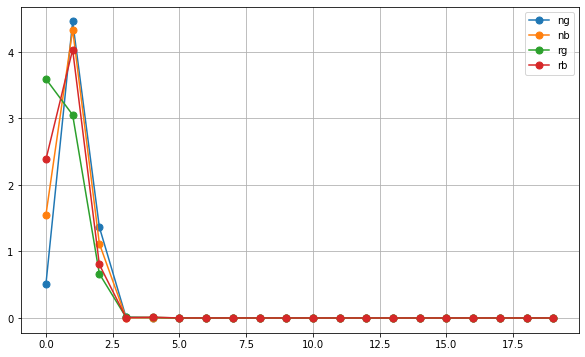

2012


<Figure size 432x288 with 0 Axes>

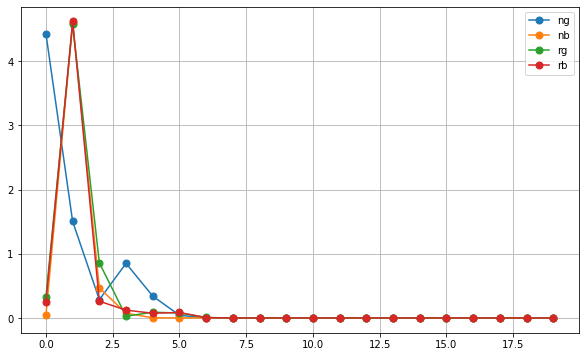

2013


<Figure size 432x288 with 0 Axes>

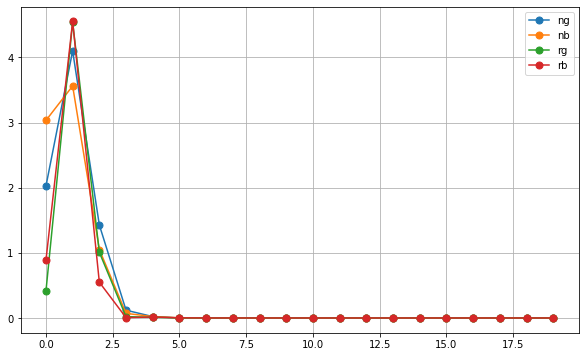

2014


<Figure size 432x288 with 0 Axes>

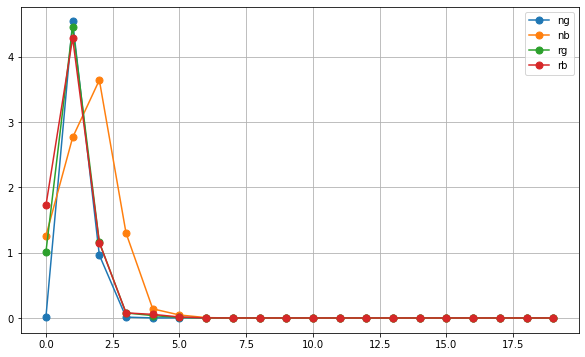

2015


<Figure size 432x288 with 0 Axes>

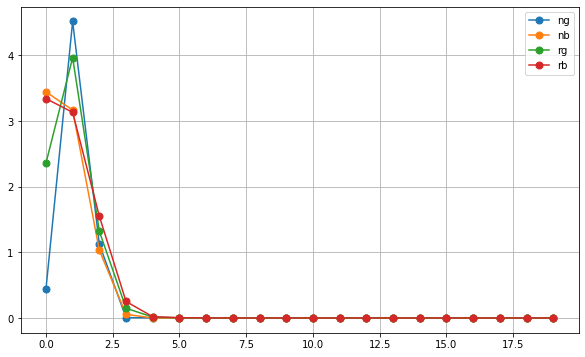

2016


<Figure size 432x288 with 0 Axes>

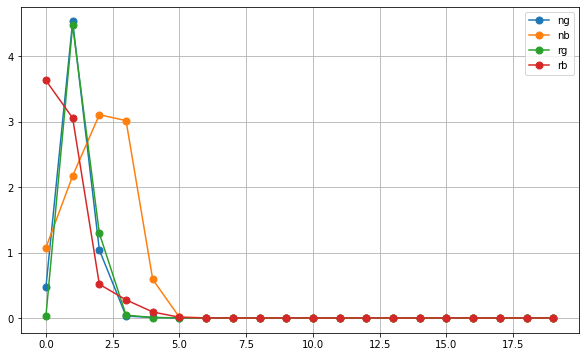

2017


<Figure size 432x288 with 0 Axes>

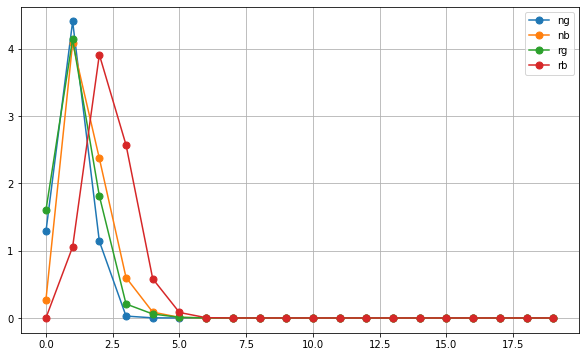

2018


<Figure size 432x288 with 0 Axes>

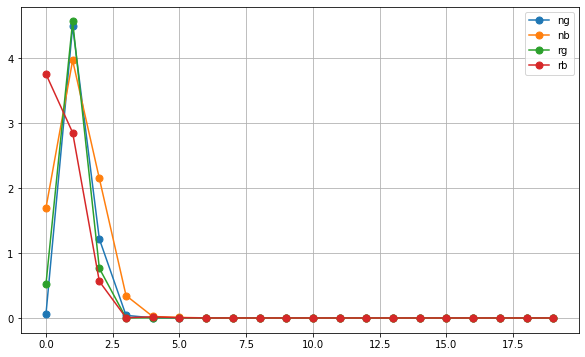

2019


<Figure size 432x288 with 0 Axes>

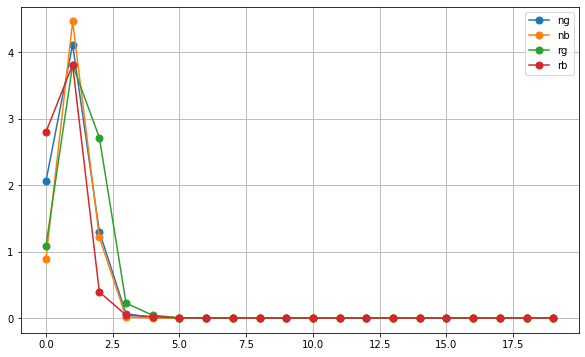

2020


<Figure size 432x288 with 0 Axes>

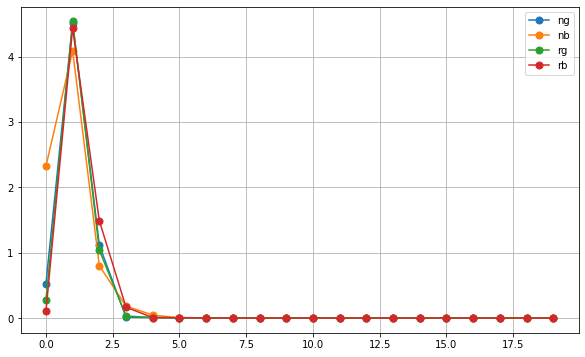

2021


<Figure size 432x288 with 0 Axes>

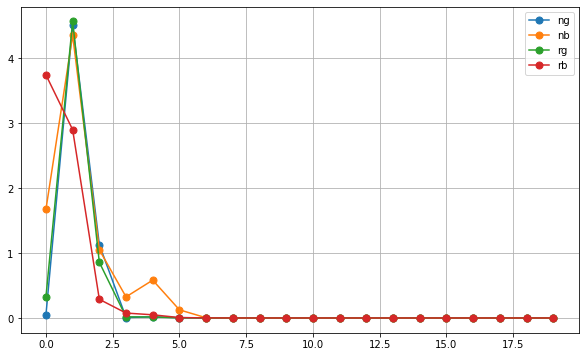

In [21]:
plot_spectrum(ffs_dict)

# Low pass cut off = 2
total profit :310.5\
mean profit :28.227272727272727\
total profit rate :12.42\
mean profit rate : 1.1290909090909091\

2011


<Figure size 432x288 with 0 Axes>

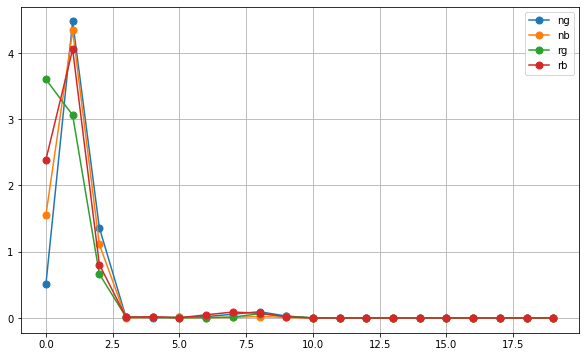

2012


<Figure size 432x288 with 0 Axes>

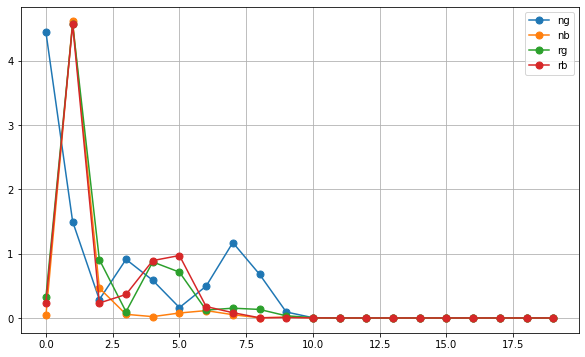

2013


<Figure size 432x288 with 0 Axes>

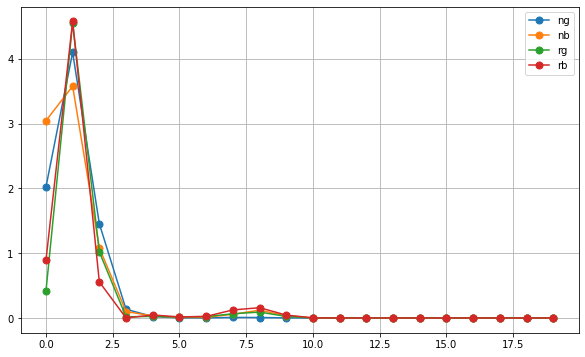

2014


<Figure size 432x288 with 0 Axes>

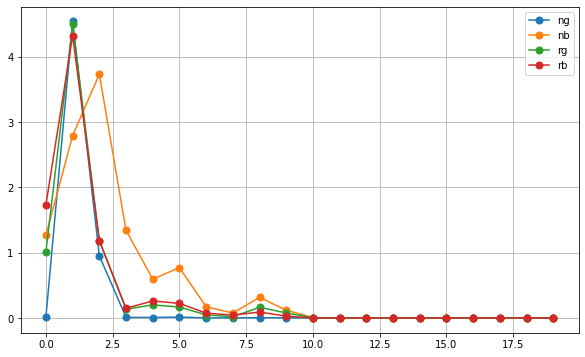

2015


<Figure size 432x288 with 0 Axes>

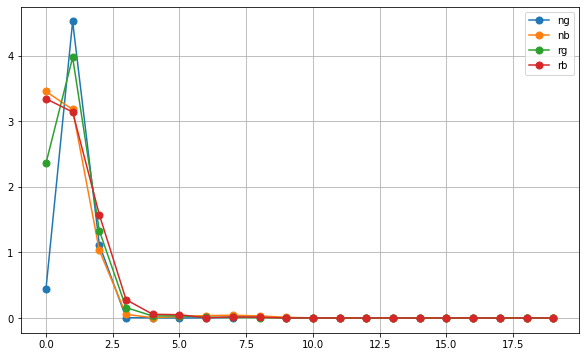

2016


<Figure size 432x288 with 0 Axes>

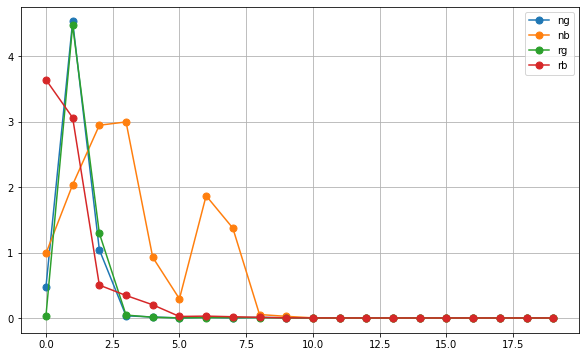

2017


<Figure size 432x288 with 0 Axes>

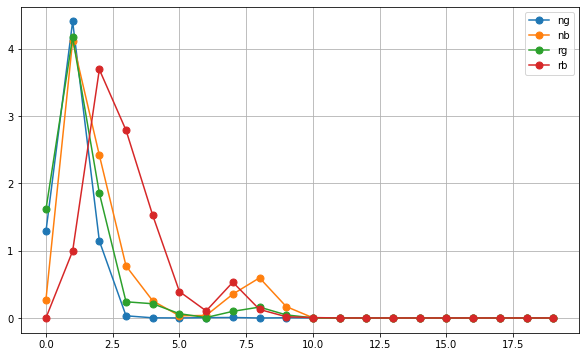

2018


<Figure size 432x288 with 0 Axes>

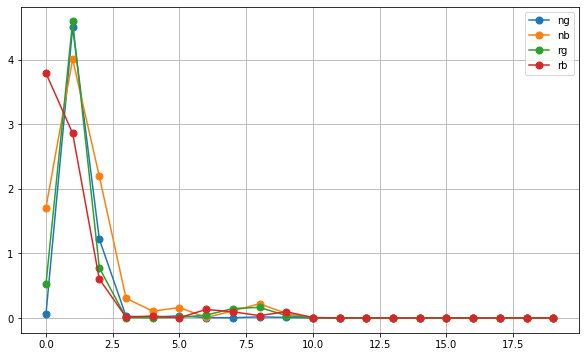

2019


<Figure size 432x288 with 0 Axes>

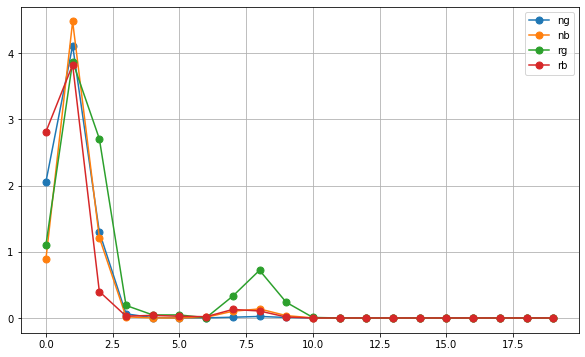

2020


<Figure size 432x288 with 0 Axes>

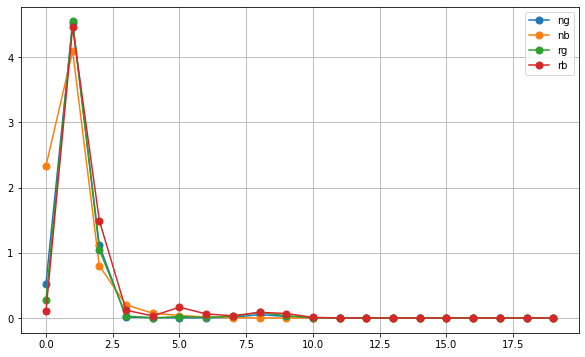

2021


<Figure size 432x288 with 0 Axes>

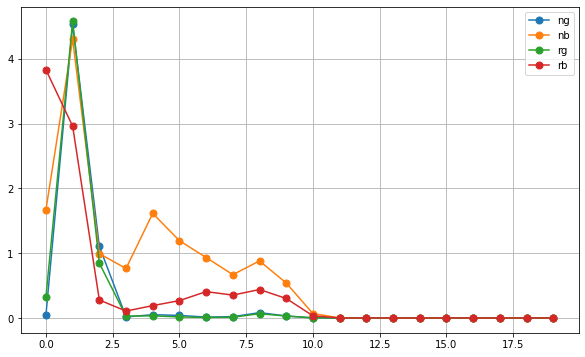

In [18]:
plot_spectrum(ffs_dict)

# Low pass cut off=3
total profit :515.5\
mean profit :46.86363636363637\
total profit rate :20.62\
mean profit rate : 1.8745454545454547

2011


<Figure size 432x288 with 0 Axes>

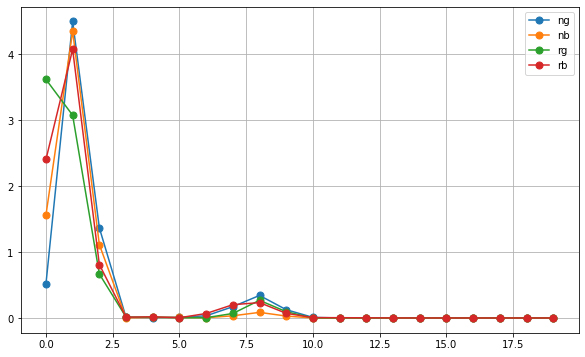

2012


<Figure size 432x288 with 0 Axes>

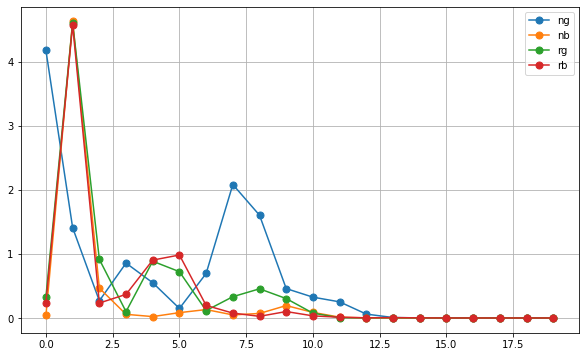

2013


<Figure size 432x288 with 0 Axes>

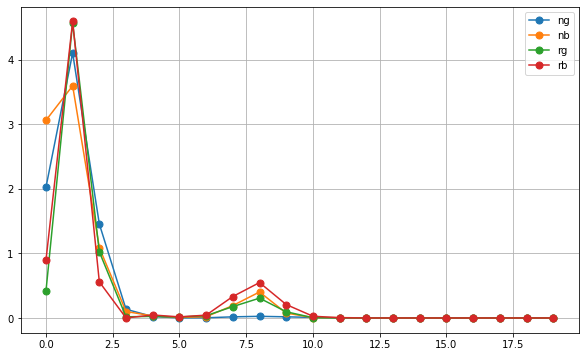

2014


<Figure size 432x288 with 0 Axes>

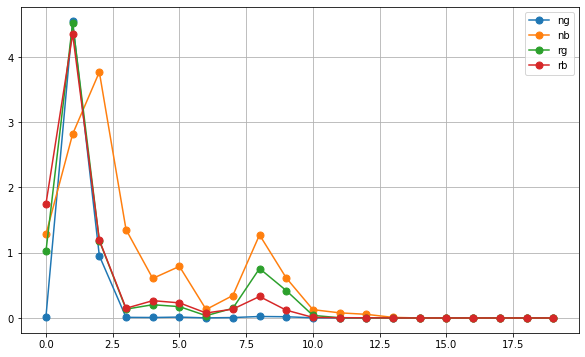

2015


<Figure size 432x288 with 0 Axes>

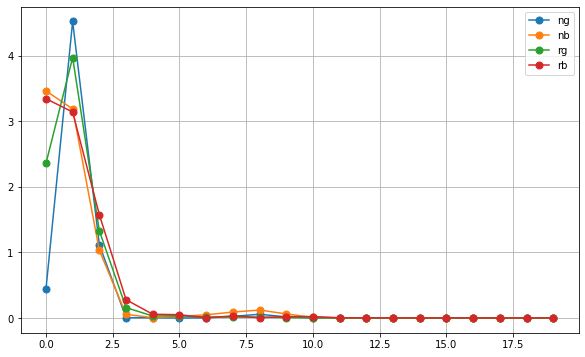

2016


<Figure size 432x288 with 0 Axes>

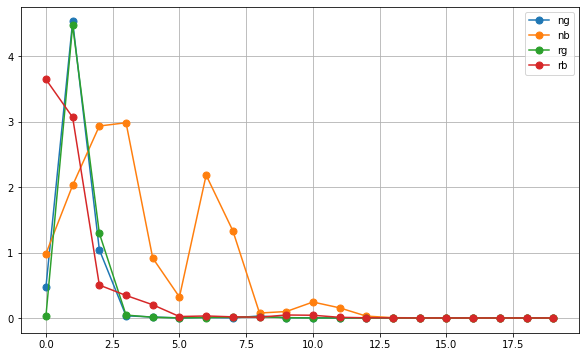

2017


<Figure size 432x288 with 0 Axes>

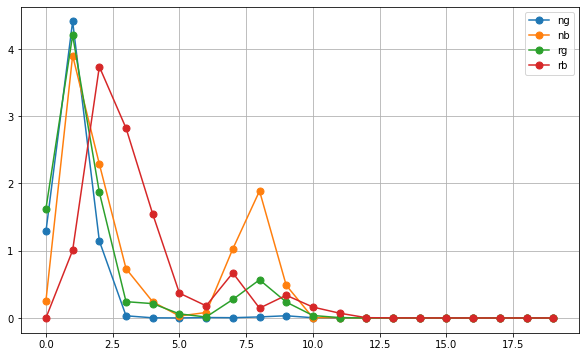

2018


<Figure size 432x288 with 0 Axes>

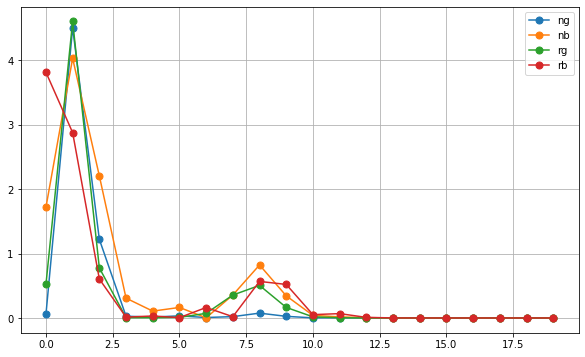

2019


<Figure size 432x288 with 0 Axes>

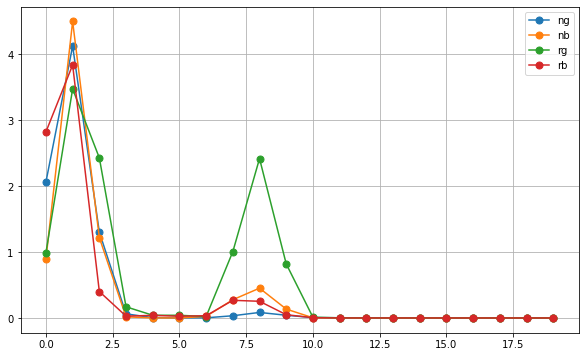

2020


<Figure size 432x288 with 0 Axes>

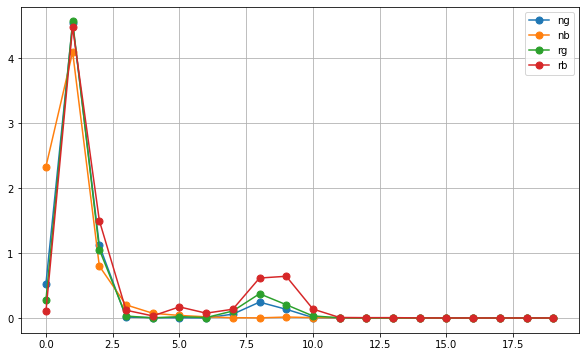

2021


<Figure size 432x288 with 0 Axes>

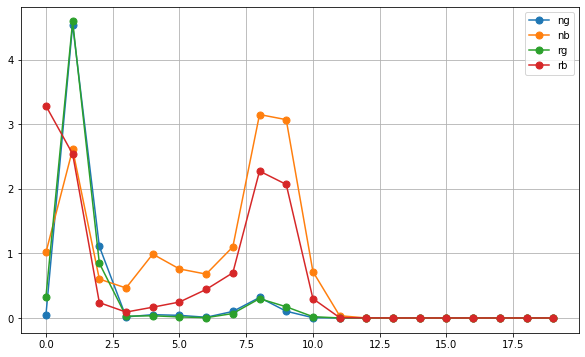

In [11]:
plot_spectrum(ffs_dict)

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
ave_wave = np.zeros(20)
width = 40
lx = LearnXGB(num_class=3)
for year in range(2012,2022):
    
    print(year)
    start_month=1
    end_month = 12
    start_year = year
    end_year = year
    value_list = value_dict[str(year-1)]
    x_ng,x_nb,x_rg,x_rb = return_clx(value_list)
    random_state=0
    n_cluster = 1
    window_type = 'bla'
    st = 1
    
    # ffs = ffs_dict[str(year)]
    # spe = ffs.Fstrategies[st].spectrum
    # """
    lc_rg = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rg.learn_clustering3(x_rg,width=width)
    lc_rb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rb.learn_clustering3(x_rb,width=width)
    lc_ng = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_ng.learn_clustering3(x_ng,width=width)
    lc_nb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_nb.learn_clustering3(x_nb,width=width)
    # """
    
    fft_dummy = FFTSimulation(lx,None,width=width,window_type=window_type)
        
    wave = lc_rb.wave_dict[0]

    spe = fft_dummy.make_spectrum(wave)
    ceps = fft_dummy.make_cepstrum(spe)
    F,Amp = fft_dummy.do_fft(wave)
    
    ave_wave += spe
    # for year in [2018,2019,2020]:
    
    # ax.plot(spe,marker='o',markersize=7)
ax.plot(ave_wave,marker='o',markersize=7)
    
        
ax.set_xlabel("Day")
ax.set_ylabel("Power")
ax.set_xticks(range(0,20,2))
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()
plt.show()

# Low pass cutoff = 4
total profit :447.5\
mean profit :40.68181818181818\
total profit rate :17.9\
mean profit rate : 1.6272727272727272

2011


<Figure size 432x288 with 0 Axes>

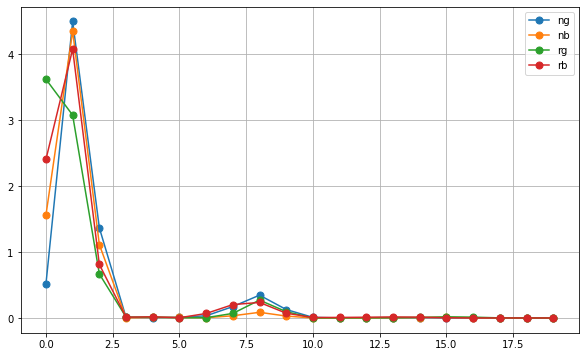

2012


<Figure size 432x288 with 0 Axes>

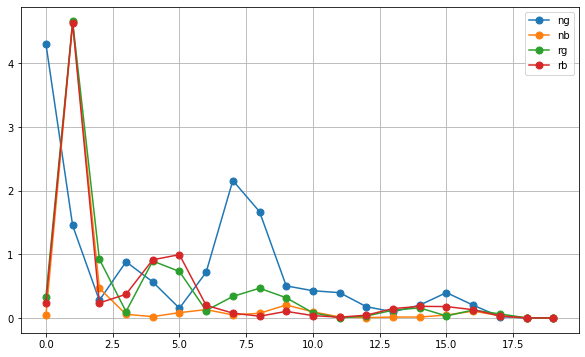

2013


<Figure size 432x288 with 0 Axes>

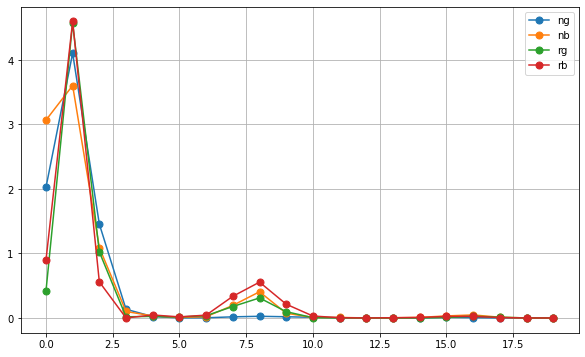

2014


<Figure size 432x288 with 0 Axes>

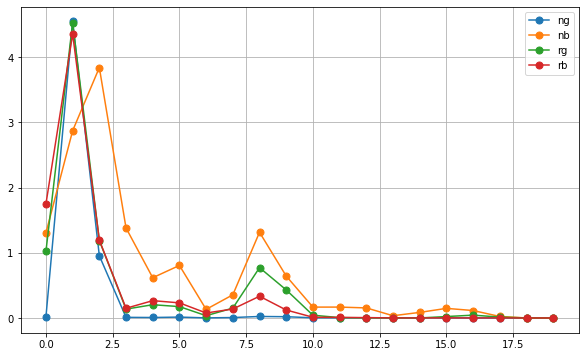

2015


<Figure size 432x288 with 0 Axes>

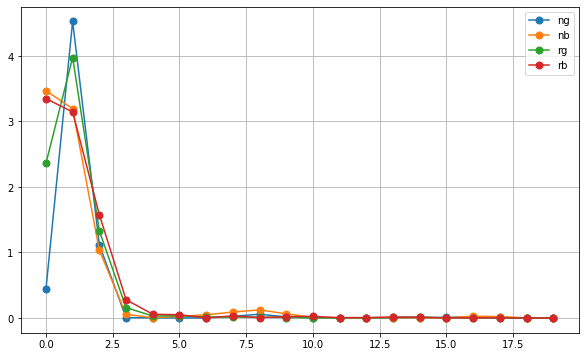

2016


<Figure size 432x288 with 0 Axes>

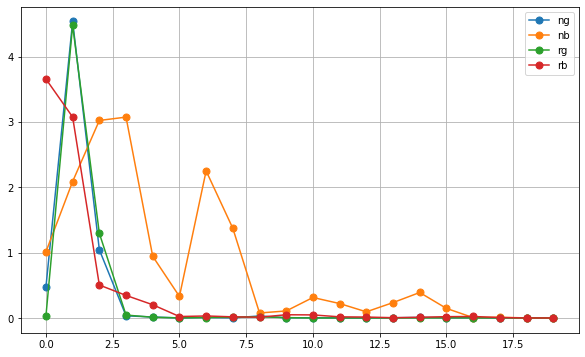

2017


<Figure size 432x288 with 0 Axes>

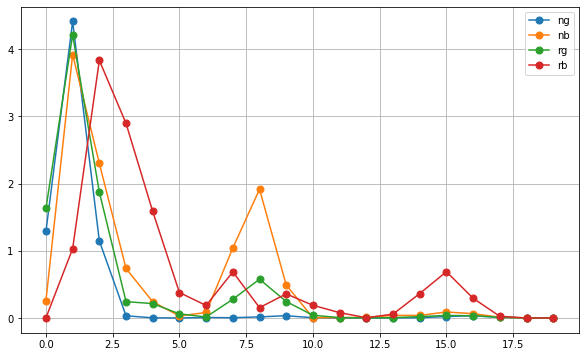

2018


<Figure size 432x288 with 0 Axes>

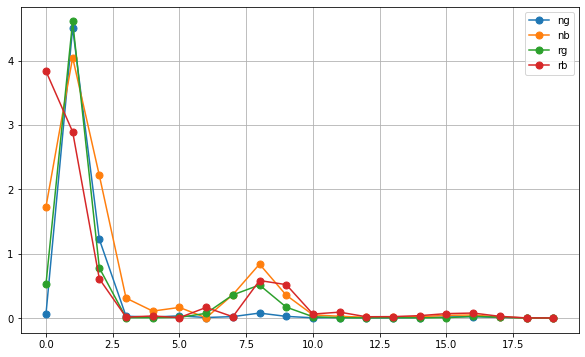

2019


<Figure size 432x288 with 0 Axes>

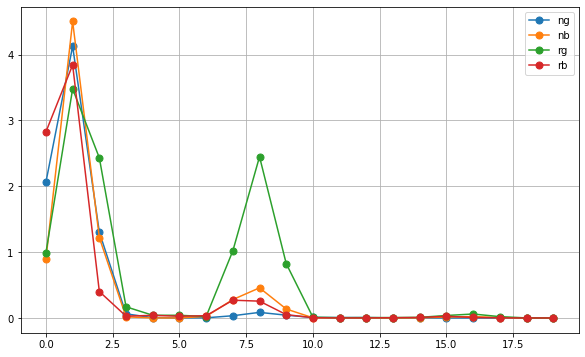

2020


<Figure size 432x288 with 0 Axes>

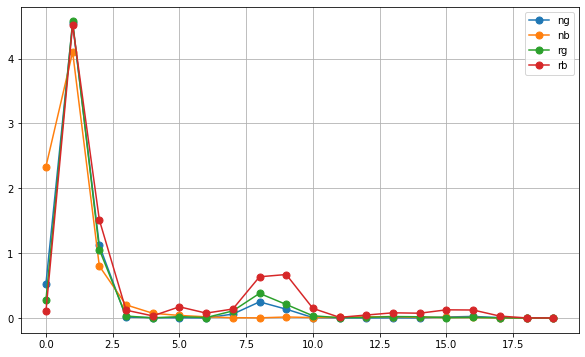

2021


<Figure size 432x288 with 0 Axes>

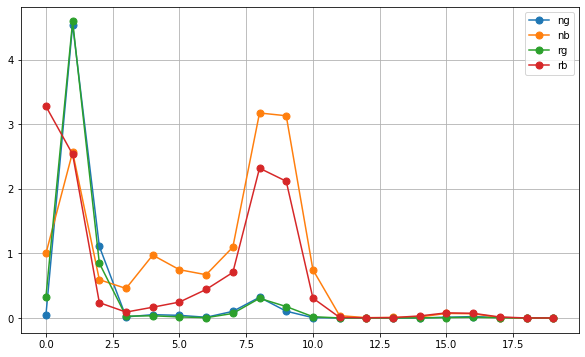

In [15]:
plot_spectrum(ffs_dict)

# High pass

# high pass cutoff = 1
total profit :495.0\
mean profit :45.0\
total profit rate :19.8\
mean profit rate : 1.8

2011


<Figure size 432x288 with 0 Axes>

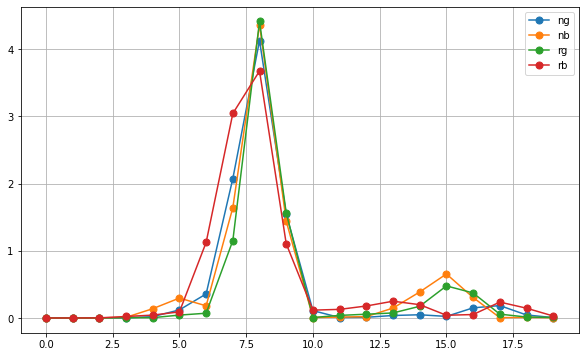

2012


<Figure size 432x288 with 0 Axes>

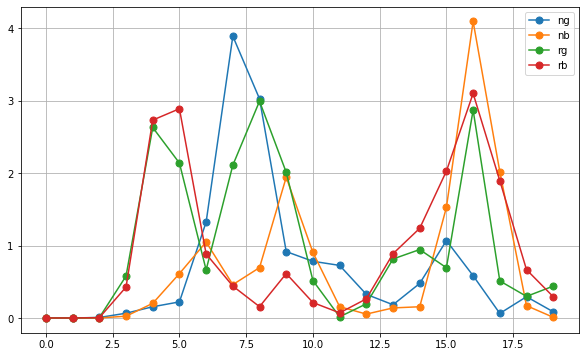

<Figure size 432x288 with 0 Axes>

2013


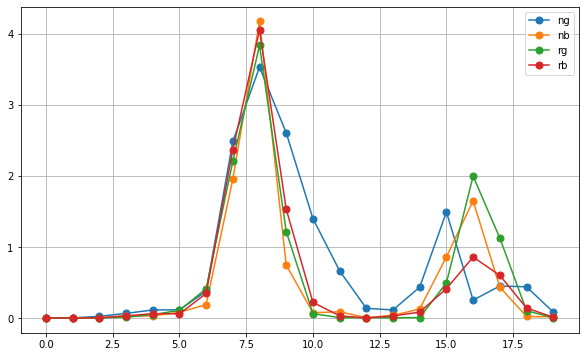

2014


<Figure size 432x288 with 0 Axes>

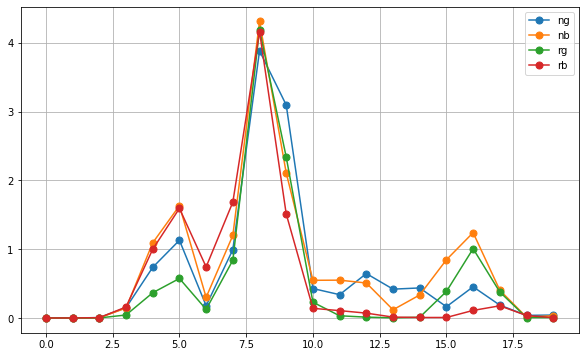

2015


<Figure size 432x288 with 0 Axes>

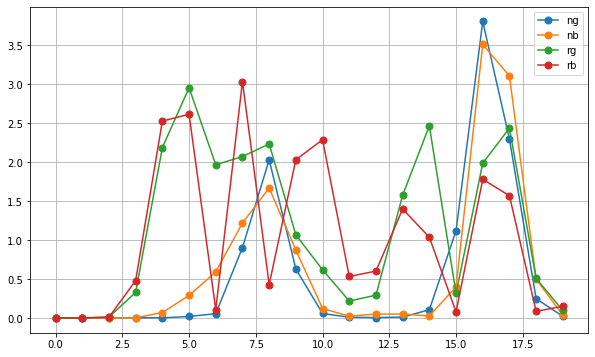

2016


<Figure size 432x288 with 0 Axes>

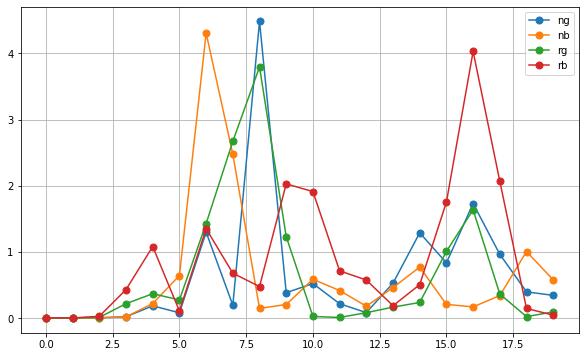

2017


<Figure size 432x288 with 0 Axes>

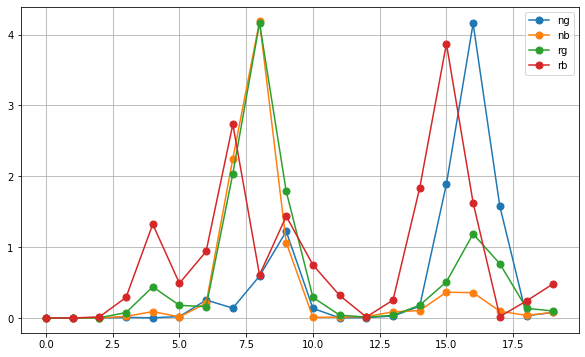

2018


<Figure size 432x288 with 0 Axes>

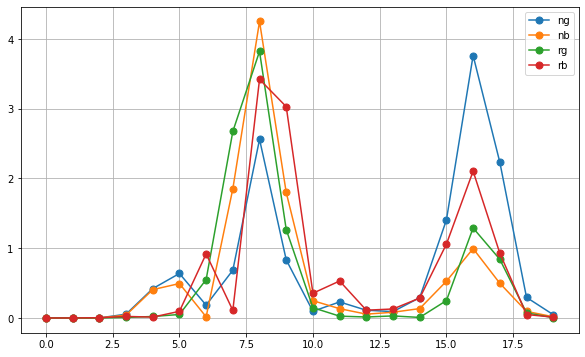

2019


<Figure size 432x288 with 0 Axes>

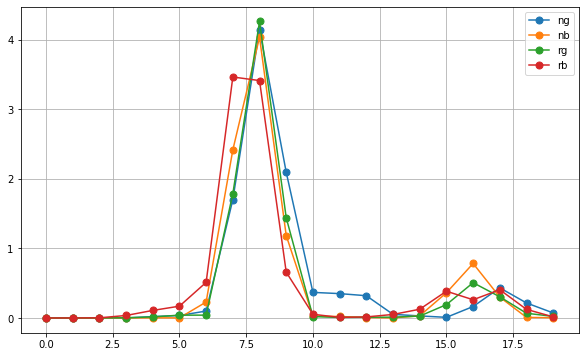

2020


<Figure size 432x288 with 0 Axes>

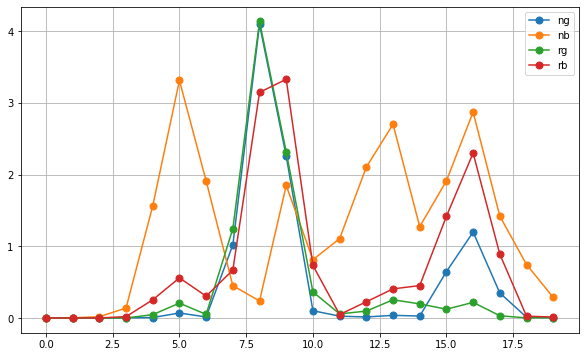

2021


<Figure size 432x288 with 0 Axes>

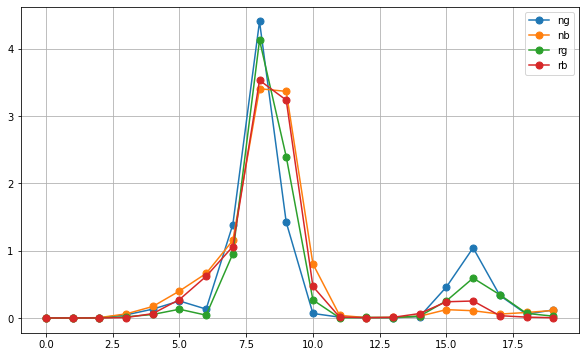

In [25]:
plot_spectrum(ffs_dict)

# high pass cutoff = 2
total profit :682.0\
mean profit :62.0\
total profit rate :27.279999999999994\
mean profit rate : 2.4799999999999995

2011


<Figure size 432x288 with 0 Axes>

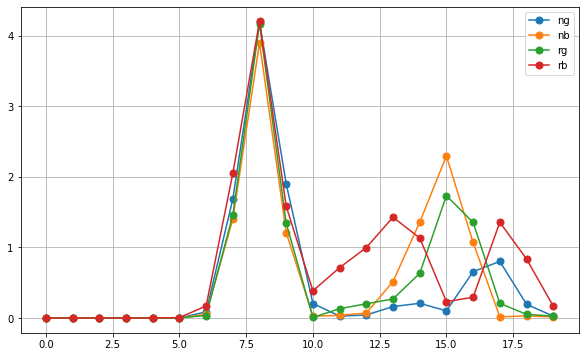

2012


<Figure size 432x288 with 0 Axes>

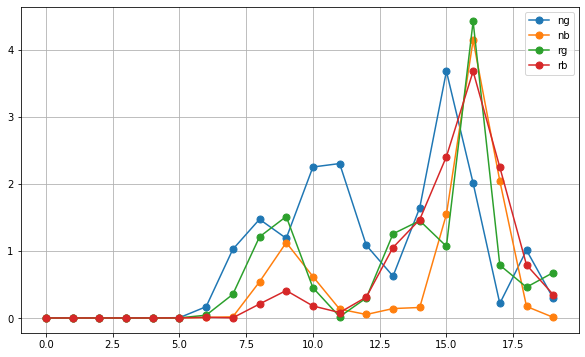

2013


<Figure size 432x288 with 0 Axes>

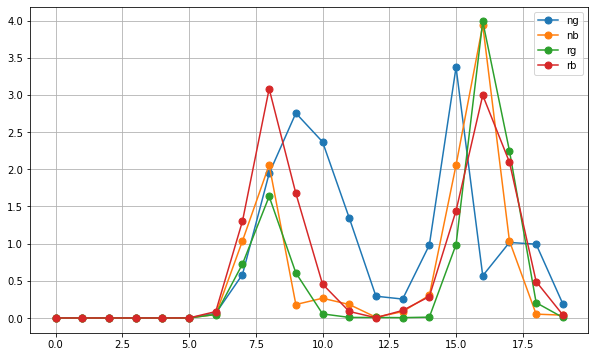

2014


<Figure size 432x288 with 0 Axes>

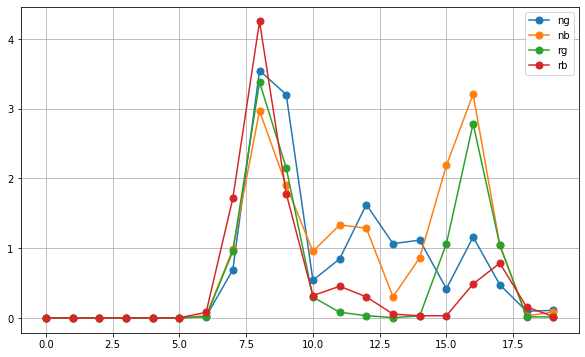

2015


<Figure size 432x288 with 0 Axes>

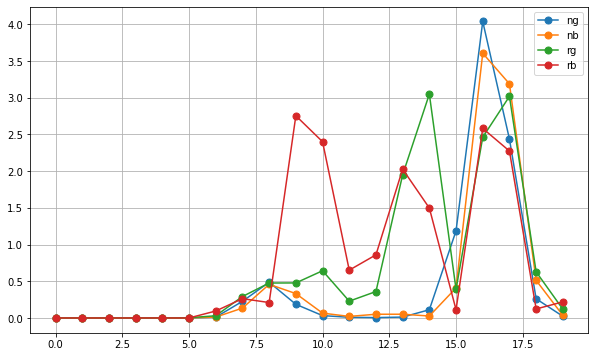

2016


<Figure size 432x288 with 0 Axes>

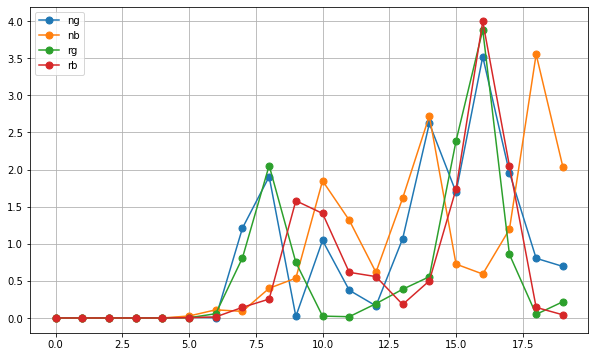

2017


<Figure size 432x288 with 0 Axes>

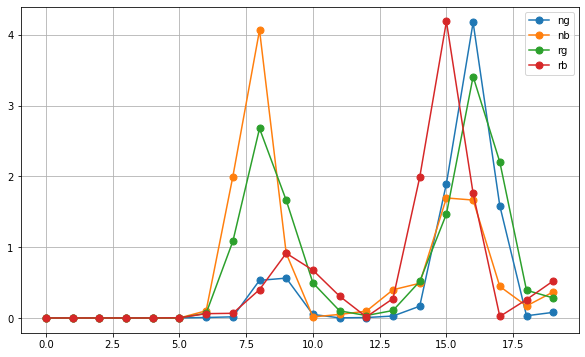

2018


<Figure size 432x288 with 0 Axes>

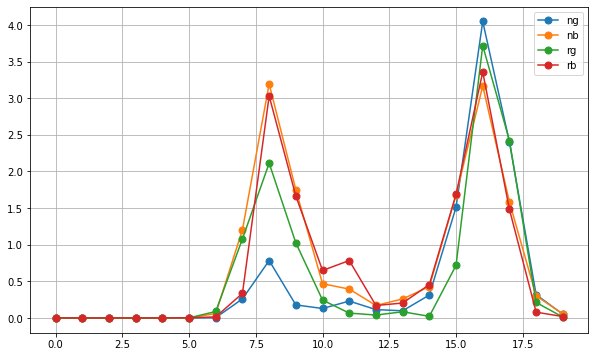

2019


<Figure size 432x288 with 0 Axes>

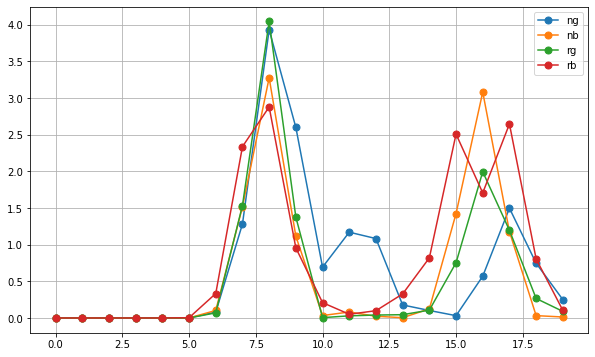

2020


<Figure size 432x288 with 0 Axes>

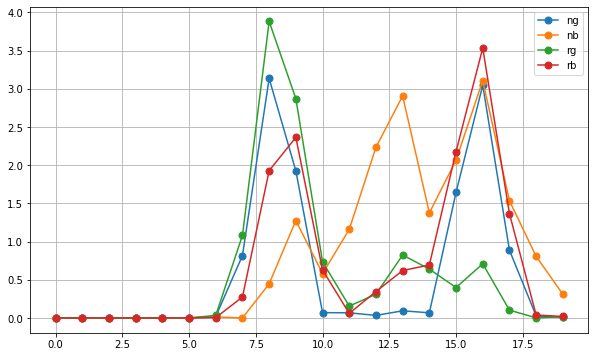

2021


<Figure size 432x288 with 0 Axes>

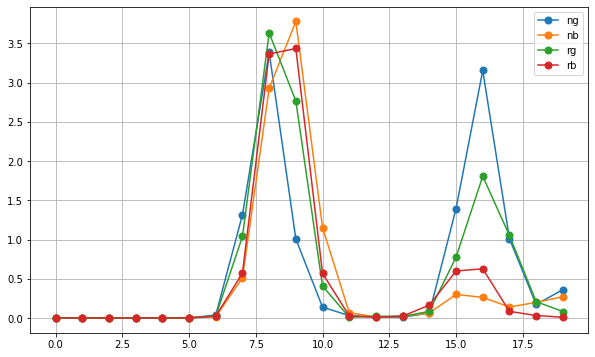

In [28]:
plot_spectrum(ffs_dict)

# high pass cutoff = 3
total profit :557.0\
mean profit :50.63636363636363\
total profit rate :22.279999999999998\
mean profit rate : 2.0254545454545454

2011


<Figure size 432x288 with 0 Axes>

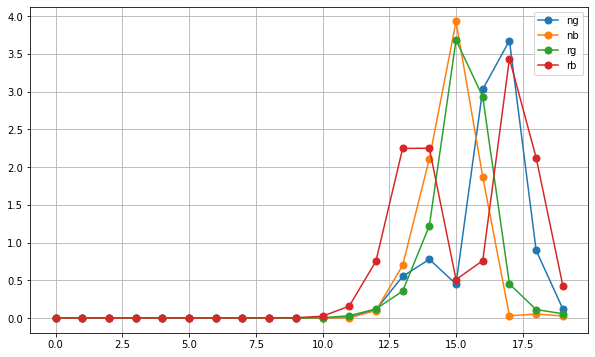

2012


<Figure size 432x288 with 0 Axes>

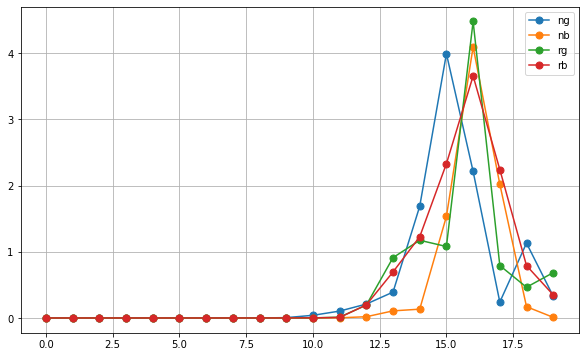

2013


<Figure size 432x288 with 0 Axes>

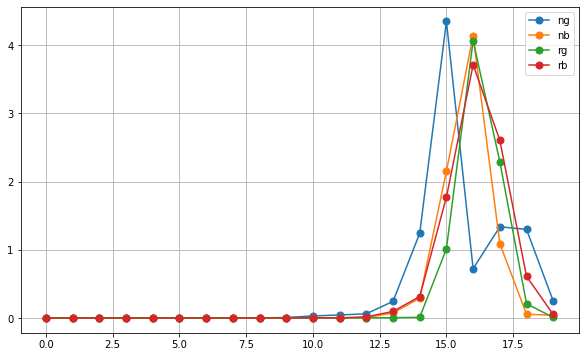

2014


<Figure size 432x288 with 0 Axes>

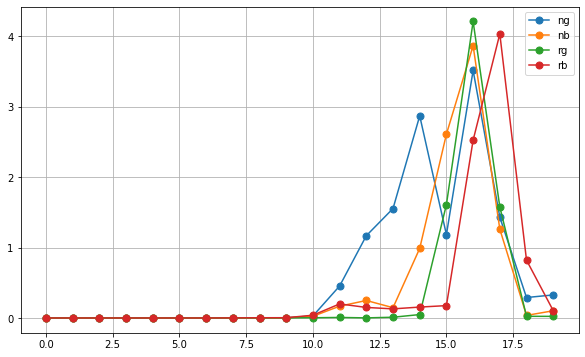

2015


<Figure size 432x288 with 0 Axes>

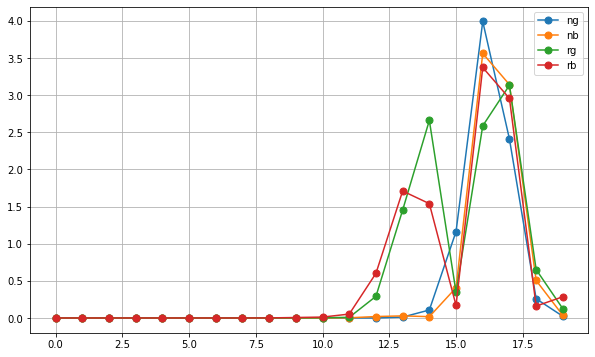

2016


<Figure size 432x288 with 0 Axes>

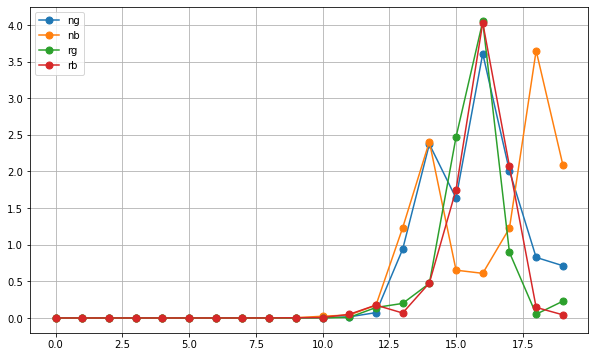

2017


<Figure size 432x288 with 0 Axes>

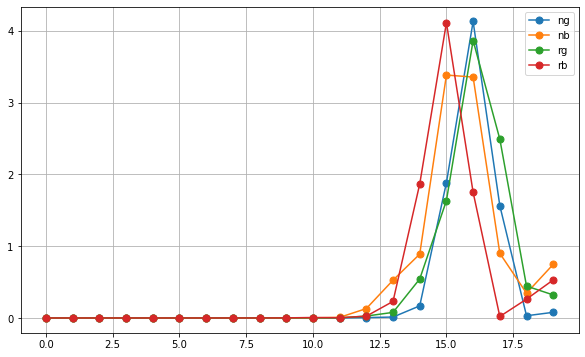

2018


<Figure size 432x288 with 0 Axes>

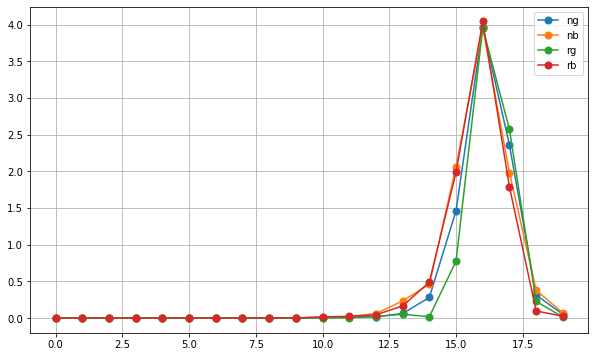

2019


<Figure size 432x288 with 0 Axes>

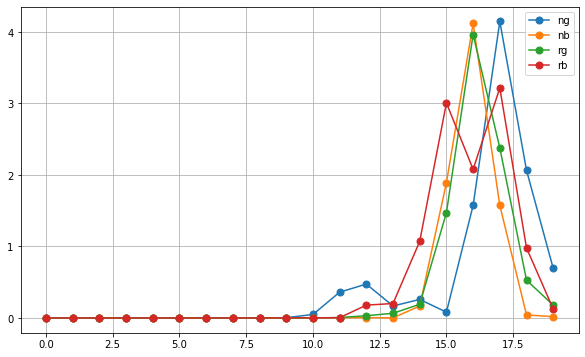

2020


<Figure size 432x288 with 0 Axes>

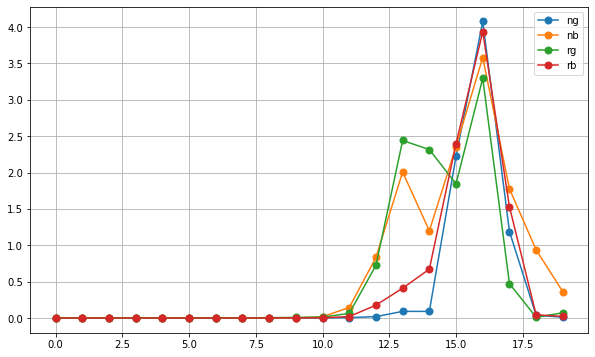

2021


<Figure size 432x288 with 0 Axes>

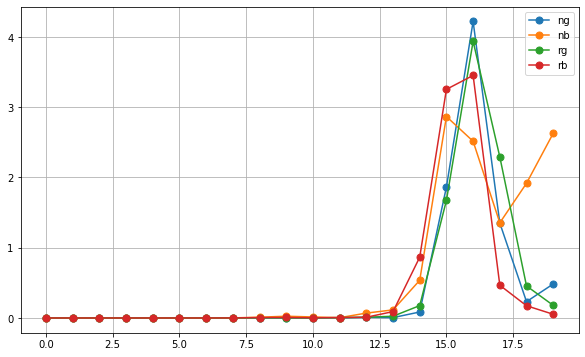

In [35]:
plot_spectrum(ffs_dict)

# high pass cutoff = 4
total profit :-115.0\
mean profit :-10.454545454545455\
total profit rate :-4.599999999999999\
mean profit rate : -0.41818181818181804

In [ ]:
plot_spectrum(ffs_dict)

# 右肩上がりか右肩下がりかだけ見る

In [501]:
uds_dict_3,trade_dict,F_lis_dict = return_uds_dict(value_dict_w20,lx_dict_w20,width=20,stride=5,window_type='bla'\
    ,is_high_pass=False,is_low_pass=True,is_ceps=False,cut_off=2,order=4)

KeyboardInterrupt: 

In [18]:

class UpDownSimulation(Simulation):
    
    
    def __init__(self,lx,Ustrategies,width=40,alpha=0.34):
        super(UpDownSimulation,self).__init__()
        self.lx = lx 
        self.xgb_model = lx.model
        self.Ustrategies = Ustrategies
        self.width = width
        self.alpha = alpha
        self.ma_long = 25
        self.ma_short = 5
    
    
    def choose_strategy(self,wave,cut_off=3,order=3):
        filtered_wave = butter_lowpass_filter(wave,cut_off,10,order=order)
        diff_wave = np.diff(filtered_wave)
        sum_diff = sum(diff_wave)
        strategy = 'none'

        # 右肩下がりの時
        if sum_diff<=0:
            strategy = 'stay'
    
        # 右肩上がりの時
        else:
            normal_wave = self.Ustrategies[0].spectrum
            reverse_wave = self.Ustrategies[2].spectrum
            
            n_cos = cos_sim(normal_wave,wave)
            r_cos = cos_sim(reverse_wave,wave)
            if n_cos>=r_cos:
                strategy = 'normal'
            else:
                strategy = 'reverse'
                
        return strategy
    
    def make_x_dict(self,path_tpx,path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)
        x_dict = {}
        lc = LearnClustering()
        x_, z_ = lc.make_x_data(df_con['close'],stride=1,test_rate=1.0,width=self.width)
        length = len(z_)

        for i in range(length):
            time_ = z_[i].index[-1]
            x_dict[time_] = standarize(x_[i])
        
        return x_dict
    

    def simulate(self, path_tpx, path_daw, is_validate=False,is_online=False,start_year=2021,end_year=2021,start_month=1,end_month=12,
        is_observed=False,cut_off=3,order=4,HOLD_DAY=8):

        x_check,y_check,y_,df_con,pl = self.simulate_routine(path_tpx, path_daw,start_year,end_year,start_month,end_month,'None',is_validate)
        self.x_check = x_check
        x_tmp,y_tmp,current_date,acc_df = self.set_for_online(x_check,y_)
        x_dict = self.make_x_dict(path_tpx,path_daw)
        length = len(x_check)
        prf_list = []
        predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
        self.predict_proba = predict_proba
        is_bought = False
        index_buy = 0
        index_sell = 0
        prf = 0
        hold_day = 0
        trigger_count = 0
        is_trigger = False
        trade_count = 0
        total_eval_price = 0
        cant_buy = 0
        buy_count = 0
        sell_count = 0
        # for debug
        self.strategies = []
        self.spe_list = []
        self.cnt_normal = 0
        self.cnt_reverse = 0
        pre_trategy = 'none'
        self.stay_detect_count = 0
        
        for i in range(length-1):

            time_ = df_con.index[i]
            wave = x_dict[time_]

            if not is_bought:
                strategy = self.choose_strategy(wave,cut_off=cut_off,order=order)
                pre_strategy = strategy

            # 差分
            if is_bought:
                strategy = self.choose_strategy(wave,cut_off=cut_off,order=order)
                if pre_strategy!='none' and (pre_strategy=='normal' or pre_strategy=='reverse') and strategy=='stay':
                    is_trigger=True
                    self.stay_detect_count += 1
                
            row = predict_proba[i]
            label = np.argmax(row)
            prob = row[label]
            total_eval_price = prf
            self.pr_log['reward'].loc[df_con.index[i]] = prf 
            self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
            tmp_date = x_tmp.index[i]   

            if is_online and current_date.month!=tmp_date.month:
                predict_proba, current_date = self.learn_online(x_tmp,y_tmp,x_check,current_date,tmp_date)


            if prob > self.alpha:
                if label == 0:
                    acc_df.iloc[i] = 0
                elif label == 1:  
                    acc_df.iloc[i] = 1
                else: #  label==2
                    acc_df.iloc[i] = 2

            if strategy=='reverse':
                self.strategies.append(-1)
                is_buy  = (label==0 and prob>self.alpha)
                is_sell = (label==2 and prob>self.alpha)
                is_cant_buy = (is_observed and (df_con['open'].loc[x_check.index[i+1]] > df_con['close'].loc[x_check.index[i]]))
                if is_buy: self.cnt_reverse += 1
            elif strategy=='normal':
                self.strategies.append(1)
                is_buy  = (label==2 and prob>self.alpha)
                is_sell = (label==0 and prob>self.alpha)
                is_cant_buy = (is_observed and (df_con['open'].loc[x_check.index[i+1]] < df_con['close'].loc[x_check.index[i]]))
                if is_buy: self.cnt_normal += 1
            elif strategy=='stay' :
                self.strategies.append(0)
                is_buy = False
                is_sell =  False
                is_cant_buy = False

            
            if not is_bought:
                if is_cant_buy:
                    cant_buy += 1
                    continue
                elif is_buy:
                    index_buy, start_time, is_bought = self.buy(df_con,x_check,i)
                    buy_count += 1

            else:
                hold_day += 1
                if hold_day>=HOLD_DAY:
                    trigger_count+=1
                    is_trigger = True
                
                # 差分
                # if is_sell or is_trigger:
                # 周期まで売らない
                if is_sell:
                    prf, trade_count, is_bought = self.sell(df_con,x_check,prf,index_buy,prf_list,trade_count,pl,start_time,i,is_validate)
                    hold_day = 0
                    is_trigger = False
                    sell_count += 1
                else:
                    total_eval_price = self.hold(df_con,index_buy,total_eval_price,i)
                    
            
            self.is_bought = is_bought
                
        
        if is_bought:
            index_sell = df_con['close'].loc[x_check.index[-1]] 
            prf += index_sell - index_buy
            prf_list.append(index_sell - index_buy)
            end_time = x_check.index[-1]
            trade_count+=1
            if not is_validate:
                pl.add_span(start_time,end_time)

        
        self.pr_log['reward'].loc[df_con.index[-1]] = prf 
        self.pr_log['eval_reward'].loc[df_con.index[-1]] = total_eval_price
        prf_array = np.array(prf_list)
        self.acc_df = acc_df
        self.y_check = y_check
            
        
        # try:
        df = self.calc_acc(acc_df, y_check)
        self.accuracy_df = df
        log = self.return_trade_log(prf,trade_count,prf_array,cant_buy)
        self.trade_log = log

        if not is_validate:
            print(log)
            print("")
            print(df)
            print("")
            print("trigger_count :",trigger_count)
            # print("buy_count",buy_count)
            # print("sell_count",sell_count)
            pl.show()
            


# Low pass best params search

In [ ]:
ffs_dict, trade_dict, F_lis_dict = \
            return_ffs_dict(value_dict,lx_dict,width=40,stride=5,window_type=window_type,\
            is_high_pass=False,is_low_pass=True,is_ceps=False,cut_off=4)

In [112]:
pr_dict = {}

for cut_off in [1,2,3,4]:
    for window_type in ['none','bla','han','ham']:
        ffs_dict, trade_dict, F_lis_dict = \
        return_ffs_dict(value_dict,lx_dict,width=40,stride=5,window_type=window_type,\
        is_high_pass=False,is_low_pass=True,is_ceps=False,cut_off=cut_off)
        total_profit,mean_profit,total_profit_rate,mean_profit_rate =plot_profit(trade_dict,verbose=True)
        pr_dict[str(cut_off)+'_'+window_type] = [total_profit,mean_profit,total_profit_rate,mean_profit_rate]
        
        

2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2011
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1        -156.0        -6.24           19        25.0      -117.0   

   mean_profit  cant_buy_count  
1    -8.210526               0  
2012
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1          19.0         0.76           16        39.0       -52.0   

   mean_profit  cant_buy_count  
1       1.1875               0  
2013
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         329.0        13.16           16       113.0       -26.0   

   mean_profit  cant_buy_count  
1      20.5625               0  
2014
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -25.0         -1.0           12       158.0       -83.0   

   mean_profit  cant_buy_count  
1    -2.083333               0  
2015
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -98.0        -3.92   

In [ ]:
for i,key in enumerate(pr_dict):
    print("---------------")
    print(key)
    print(pr_dict[key])

In [ ]:
plot_spectrum(ffs_dict)

# 凡例作っています

In [72]:
uds_dict

{'2011': <my_library.library.UpDownSimulation at 0x24c9db0d7c0>,
 '2012': <my_library.library.UpDownSimulation at 0x24cf334f0d0>,
 '2013': <my_library.library.UpDownSimulation at 0x24cf3339f70>,
 '2014': <my_library.library.UpDownSimulation at 0x24cf3331700>,
 '2015': <my_library.library.UpDownSimulation at 0x24cf333ec70>,
 '2016': <my_library.library.UpDownSimulation at 0x24cf32e52e0>,
 '2017': <my_library.library.UpDownSimulation at 0x24cf32dc790>,
 '2018': <my_library.library.UpDownSimulation at 0x24cf32cae80>,
 '2019': <my_library.library.UpDownSimulation at 0x24cf32fe430>,
 '2020': <my_library.library.UpDownSimulation at 0x24cf335ba60>,
 '2021': <my_library.library.UpDownSimulation at 0x24cf337cfd0>}

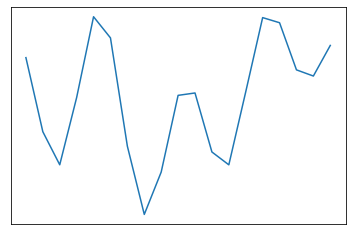

In [141]:
# spe = ffs_dict['2011'].Fstrategies[0].spectruma

plt.clf()
plt.plot(spe_d)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

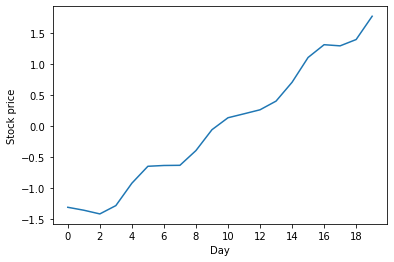

In [552]:

plt.clf()
spe = uds_dict['2018'].Ustrategies[0].spectrum
ax = plt.gca()
ax.set_xlabel('Day')
ax.set_ylabel('Stock price')
ax.set_xticks(range(0,20,2))
ax.plot(spe)

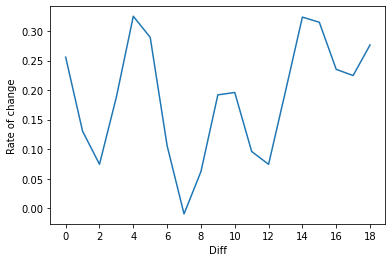

In [277]:
plt.clf()
ax = plt.gca()
ax.set_xlabel('Diff')
ax.set_ylabel('Rate of change')
ax.set_xticks(range(0,20,2))
ax.plot(spe_d)

In [77]:
spe = uds_dict['2011'].Ustrategies[1].spectrum

<Figure size 432x288 with 0 Axes>

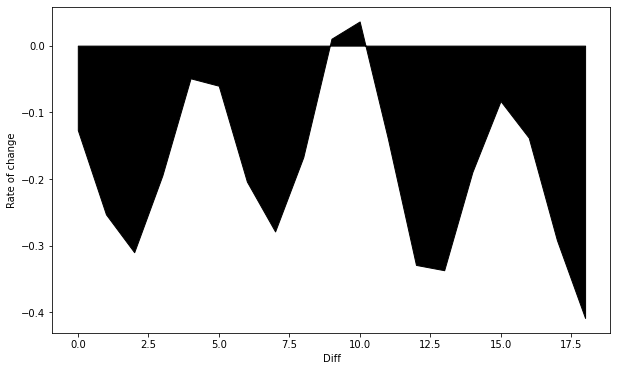

In [79]:
from turtle import color


spe_f = butter_lowpass_filter(spe,4,20)
spe_d = np.diff(spe_f)
plt.clf()
fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
ax.set_xlabel('Diff')
ax.set_ylabel('Rate of change')
# ax.set_xticks(range(0,20,2))
ax.fill_between(range(19),spe_d,np.zeros(19),color='black')
# ax.axhspan(0,18,0,5)

# ax.plot(spe_d)
# ax.grid()
plt.show()


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


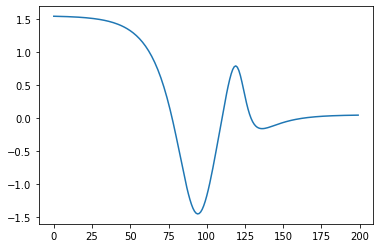

In [378]:
plt.plot(h)

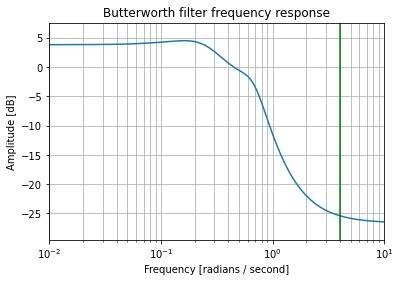

In [379]:
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(4, color='green') # cutoff frequency

plt.show()

In [68]:
spe_down2 = uds_dict['2013'].Ustrategies[1].spectrum

In [140]:
high_ = 2908967
low_ = 2899074
(high_ - low_)/low_
0.006

0.0034124689469810015

[]

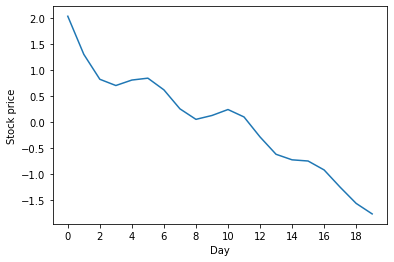

In [73]:
plt.clf()
spe_f = butter_lowpass_filter(spe_down2,  4, 20)
ax = plt.gca()
ax.set_xlabel('Day')
ax.set_ylabel('Stock price')
ax.set_xticks(range(0,20,2))
ax.plot(spe_f)
plt.plot()


# ここでcutoff

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

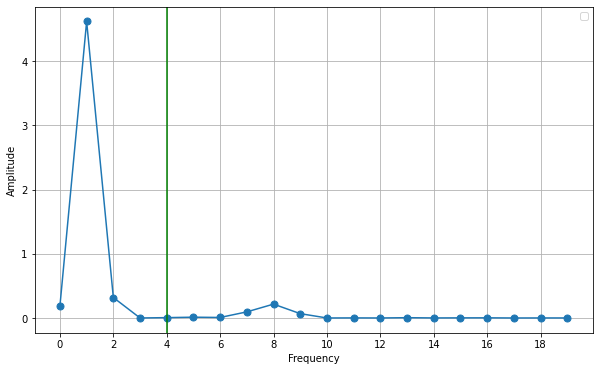

In [387]:
spec = ffs_dict['2011'].Fstrategies[0].spectrum
plt.plot(spec)

plt.clf()
fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")


ax.plot(spec,marker='o',markersize=7)

ax.set_xticks(range(0,20,2))
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
ax.grid()
ax.axvline(4, color='green')
ax.legend()
plt.show()

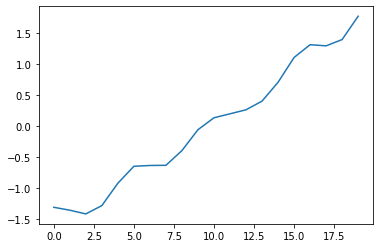

In [579]:
plt.plot(spe)

In [146]:
spe_t = uds_dict_tmp['2011'].Ustrategies[0].spectrum

In [147]:
spe_f = butter_lowpass_filter(spe_t,  4, 20)
spe_d = np.diff(spe_f)

<Figure size 432x288 with 0 Axes>

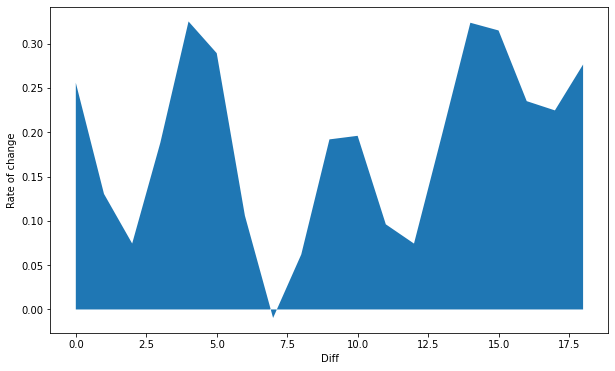

In [149]:
plt.clf()
# plt.plot(spe_d)
spe_d = np.diff(spe_f)
fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
ax.set_xlabel('Diff')
ax.set_ylabel('Rate of change')
# ax.set_xticks(range(0,20,2))
ax.fill_between(range(19),spe_d,np.zeros(19))
# ax.axhspan(0,18,0,5)

# ax.plot(spe_d)
# ax.grid()
plt.show()

In [102]:
from sympy import *

# 移動平均

In [6]:
# uds_dict_tmp = load_pickle('/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/uds_dict.pickle')

In [7]:
spe_t = uds_dict_tmp['2011'].Ustrategies[0].spectrum

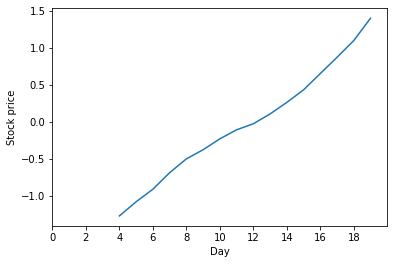

In [37]:
# num = 5
# b = np.ones(num)/num
# spe_t2 = np.convolve(spe_t,b,mode='same')

import bottleneck as bn
ma_wave = bn.move_mean(spe_t,window=5)
ax = plt.gca()
ax.set_xlabel('Day')
ax.set_ylabel('Stock price')
ax.set_xticks(range(0,20,2))
ax.set_xlim(0, 20)
# ax.set_ylim(
ax.plot(ma_wave)

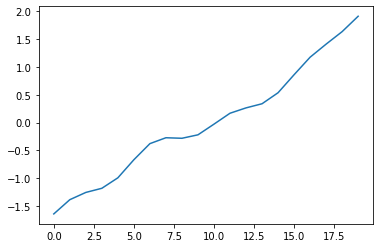

In [11]:
spe_f = butter_lowpass_filter(spe_t,  2, 10)
plt.plot(spe_f)

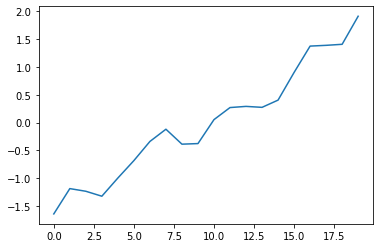

In [144]:
plt.plot(uds_dict['2011'].Ustrategies[0].spectrum)

# ave_wave

In [34]:
ave_wave = np.zeros(20)
ave_wave_dict = {}  

st = 0

for st in [0]:

    ave_wave = np.zeros(20)
    for idx,key in enumerate(uds_dict):
        # if key=='2017':break
        uds = uds_dict[key]
        wave = uds.Ustrategies[st].spectrum
        wave_low_pass = butter_lowpass_filter(wave,4,20)
        # ax.plot(wave_low_pass)
        
        ave_wave += wave
        # break
    ave_wave_dict[st] = standarize(ave_wave)


0
1
2
3


<Figure size 432x288 with 0 Axes>

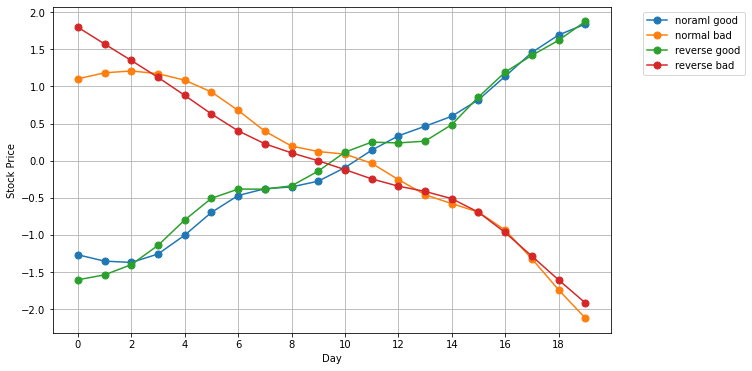

In [47]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")

for i,key in enumerate(ave_wave_dict):
    wave = ave_wave_dict[key]
    if key==0:
        label = 'noraml good'
    elif key==1:
        label = 'normal bad'
    elif key==2:
        label = 'reverse good'
    elif key==3:
        label = 'reverse bad'
        
    print(key)
    # ax.plot(wave,label=label,marker='o',markersize=7)
    wave_low_pass = butter_lowpass_filter(wave,4,20)
    ax.plot(wave_low_pass,label=label,marker='o',markersize=7)
    
        
ax.set_xlabel("Day")
ax.set_ylabel("Stock Price")
ax.set_xticks(range(0,20,2))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.legend()
ax.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

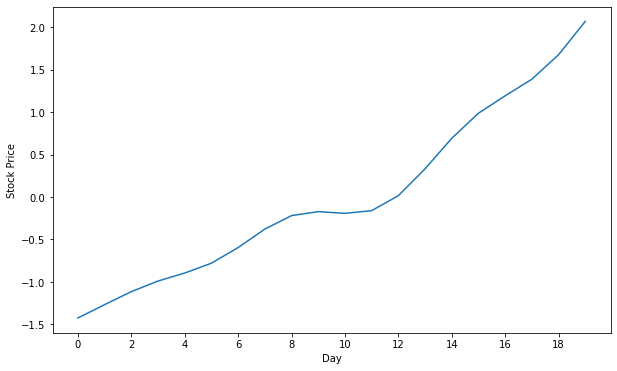

In [68]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
# ax.plot(ave_wave_dict[2],label='normal bad',marker='o',markersize=7)
wave = uds_dict['2015'].Ustrategies[2].spectrum
wave_low_pass = butter_lowpass_filter(wave,4,20)
ax.plot(wave_low_pass)
ax.set_xlabel("Day")
ax.set_ylabel("Stock Price")
ax.set_xticks(range(0,20,2))
# ax.grid()
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [71]:
cos_sim(wave_low_pass0,wave_low_pass1)

0.9901998862897337

<Figure size 432x288 with 0 Axes>

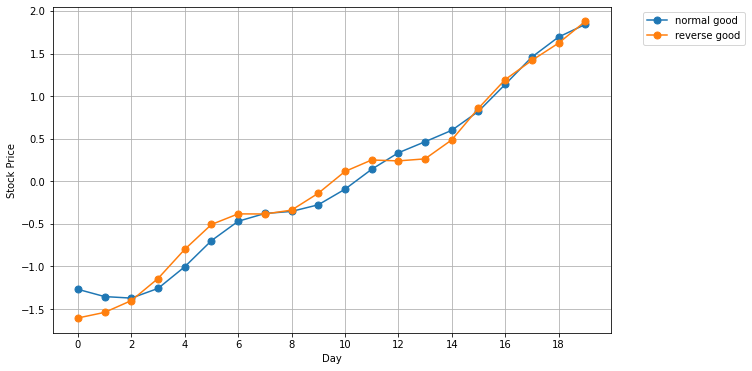

In [70]:
from turtle import color


plt.clf()
fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
# ax.plot(ave_wave_dict[2],label='normal bad',marker='o',markersize=7)
wave_low_pass0 = butter_lowpass_filter(ave_wave_dict[0],4,20)
ax.plot(wave_low_pass0,label='normal good',marker='o',markersize=7)

wave_low_pass1 = butter_lowpass_filter(ave_wave_dict[2],4,20)
ax.plot(wave_low_pass1,label='reverse good',marker='o',markersize=7)
ax.set_xlabel("Day")
ax.set_ylabel("Stock Price")
ax.set_xticks(range(0,20,2))
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<Figure size 432x288 with 0 Axes>

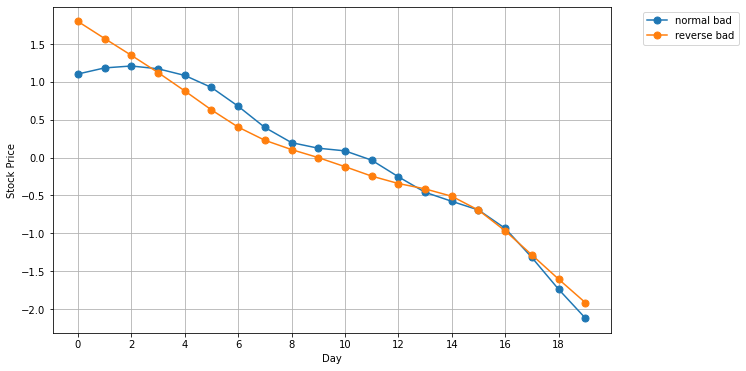

In [51]:


plt.clf()
fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
# ax.plot(ave_wave_dict[2],label='normal bad',marker='o',markersize=7)
wave_low_pass = butter_lowpass_filter(ave_wave_dict[1],4,20)
ax.plot(wave_low_pass,label='normal bad',marker='o',markersize=7)

wave_low_pass = butter_lowpass_filter(ave_wave_dict[3],4,20)
ax.plot(wave_low_pass,label='reverse bad',marker='o',markersize=7)
ax.set_xlabel("Day")
ax.set_ylabel("Stock Price")
ax.set_xticks(range(0,20,2))
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [175]:
log_dict = {}

for year in range(2012,2022):
    uds = uds_dict[str(year)]
    uds.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=True)
    trade_log = uds.trade_log
            
    log_dict[year] = trade_log
    
    

In [182]:
key

'2021'

In [23]:
log_dict

{'2012':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1          81.0         3.24           15        53.0       -30.0   
 
    mean_profit  cant_buy_count  
 1          5.4               0  ,
 '2013':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1         316.0        12.64           21        99.0       -77.0   
 
    mean_profit  cant_buy_count  
 1    15.047619               0  ,
 '2014':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1         -24.0        -0.96           21        58.0       -42.0   
 
    mean_profit  cant_buy_count  
 1    -1.142857               0  ,
 '2015':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1         131.0         5.24           18        84.0       -55.0   
 
    mean_profit  cant_buy_count  
 1     7.277778               0  ,
 '2016':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1          45.0          1.8           16    

# 棒グラフ作成

In [246]:
plot_ = ''
total_pr = 0
pr_list = []
cumulative_pr_list = []
for i,key in enumerate(log_dict):
    
    # if int(key)>=2017:
    
    trade_log = log_dict[key]
    total_profit = trade_log['profit rate'].values[0]
    pr_list.append(total_profit)
    total_pr += total_profit
    cumulative_pr_list.append(total_pr)
    plot_ += ' & ' + '{:.2f}'.format(total_profit)
    
plot_ += ' \\\\'
print(plot_)
# pr_list.append(total_pr)


 & 3.24 & 12.64 & -0.96 & 5.24 & 1.80 & -0.24 & -8.44 & 4.92 & 10.16 & 1.98 \\


# Technical 

<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

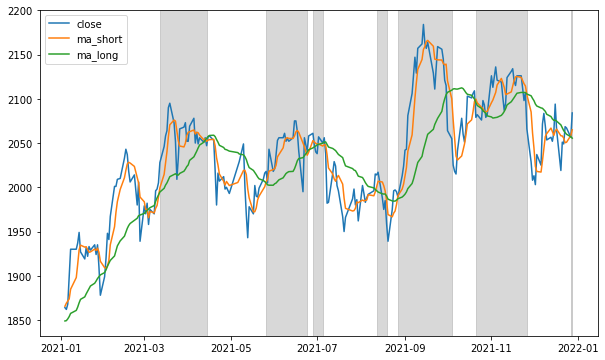

In [247]:
pr_list_ts = []
total_profit = 0
cumulative_pr_list_ts = []
for year in range(2012,2022):
    ts = TechnicalSimulation(hold_day=100)
    ts.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=True)
    trade_log = ts.trade_log
    profit_rate = trade_log['profit rate'].values[0]
    total_profit += profit_rate
    pr_list_ts.append(profit_rate)
    cumulative_pr_list_ts.append(total_profit)
# pr_list_ts.append(total_profit)

# 棒グラフ　描画

In [90]:
def plot_var(pr_list_ts,pr_list,key):
    height1 = pr_list_ts.copy()
    height2 = pr_list.copy()


    left = np.arange(len(height1))  # numpyで横軸を設定
    labels = [str(year) for year in range(2017,2022)]
    # labels.append('Total')


    width = 0.4
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
    ax.bar(left, height1, color='darkgray', width=width, align='center',label='Golden and Dead')
    ax.bar(left+width, height2, color='#377eb8', width=width, align='center',label='Proposed method')

    plt.xticks(left + width/2, labels)
    ax.set_xlabel(key)
    ax.set_ylabel("Rate of return (%)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_xticks(labels)

    plt.show()

# Cumulative plot

In [248]:
len(cumulative_pr_list)

10

In [145]:
def plot_cumulative_var(cumulative_pr_list_ts,cumulative_pr_list,key):
    height1 = cumulative_pr_list_ts.copy()
    height2 = cumulative_pr_list.copy()


    left = np.arange(len(height1))  # numpyで横軸を設定
    labels = [str(year) for year in range(2012,2022)]
    # labels.append('Total')


    width = 0.4
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
    ax.bar(left, height1, color='darkgray', width=width, align='center',label='Golden and Dead')
    ax.bar(left+width, height2, color='#377eb8', width=width, align='center',label='Proposed method')

    plt.xticks(left + width/2, labels)
    ax.set_xlabel(key)
    ax.set_ylabel("Cumulative rate of return (%)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_xticks(labels)

    plt.show()

In [89]:
def get_gyosyu_df(path_gyosyu = '/Users/Owner/Desktop/StockPriceData/Gyosyu/'):
    FILE = glob.glob(path_gyosyu+'*.csv')
    df_dict = {}
    for file in FILE:
        name = file.replace(path_gyosyu,'')[:-4]
        df = pd.read_csv(file)
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:'open',\
                                    df.columns[6]:'high',df.columns[7]:'low',df.columns[8]:'close',\
                                        df.columns[9]:'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)
        df_dict[name] = df

    return df_dict,FILE

In [194]:
df_dict, FILE = get_gyosyu_df()

total_profit  profit rate  trade_count  max_profit  min_profit  \
1           0.0          0.0            0         0.0         0.0   

   mean_profit  cant_buy_count  
1          0.0               0

<Figure size 432x288 with 0 Axes>

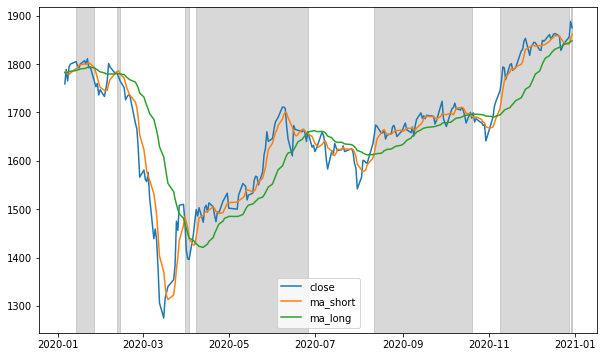

In [196]:
ts = TechnicalSimulation(hold_day=100)
ts.simulate(path_tpx,path_daw,start_year=2020,end_year=2020,is_validate=True)

df_dummy = ts.trade_log.copy()
df_dummy.loc[1] = 0
df_dummy

In [197]:
trade_log_dict = {}

for file in FILE:
    df_ = df_dummy.copy()
    for year in [2016,2017,2018,2019,2020,2021]:
        start_year = year
        end_year = year
        uds = uds_dict[str(year)]
        uds.simulate(file,path_daw,start_year=start_year,end_year=end_year,is_validate=True)
        trade_log = uds.trade_log
        df_.loc[1] += trade_log.loc[1]
    trade_log_dict[file[43:].replace('.csv','')] = df_

In [324]:
trade_log_dict

{'DENKIKIKI':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1        126.59       5.0636           99     1054.78     -872.69   
 
    mean_profit  cant_buy_count  
 1     9.358922               0  ,
 'DENKI_GASS':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1       -127.95       -5.118           43       84.57     -125.46   
 
    mean_profit  cant_buy_count  
 1   -19.164583               0  ,
 'GARAS_DOSEKI':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1        274.81      10.9924           76      370.88     -278.49   
 
    mean_profit  cant_buy_count  
 1    22.053082               0  ,
 'GINKOU':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1        126.59       5.0636           99     1054.78     -872.69   
 
    mean_profit  cant_buy_count  
 1     9.358922               0  ,
 'GOMU':    total_profit  profit rate  trade_count  max_profit  min_profit  \
 1        378.98      15.

In [92]:
ts = TPXSimulation()
df = ts.make_df_con(path_tpx,path_daw)
ex_tpx_dict = {}

for year in [2016,2017,2018,2019,2020,2021]:
    df_tmp = df[df.index.year==year]
    mean_close = df_tmp.mean()['close']
    ex_tpx_dict[year] = mean_close
    

# UDS 業種別

In [94]:
trade_log_joui5['DENKIKIKI'][0][0]['profit rate'].values[0]

-0.23599999999997634

In [99]:
len(trade_log_joui5['DENKIKIKI'])

5

In [118]:
trade_log_kai5

{'GINKOU': [[   total_profit  profit rate  trade_count  max_profit  min_profit  \
   1          3.07       0.1228           15        5.77       -8.19   
   
      mean_profit  cant_buy_count  
   1     0.204667               0  ,
      score  Up precision  Down precision  Up recall  Down recall  up_num  \
   0  0.375      0.222973        0.619565   0.485294     0.331395    68.0   
   
      down_num  
   0     172.0  ,
               reward  eval_reward
   day                            
   2017-01-04    0.00         0.00
   2017-01-05    0.00         0.00
   2017-01-06    0.00         0.00
   2017-01-10    0.00         0.00
   2017-01-11   -0.05        -0.05
   ...            ...          ...
   2017-12-22   -0.23         5.41
   2017-12-25   -0.23        -0.23
   2017-12-26    3.07         3.07
   2017-12-27    3.07         3.07
   2017-12-28    3.07         3.07
   
   [240 rows x 2 columns]],
  [   total_profit  profit rate  trade_count  max_profit  min_profit  \
   1         -8.4

In [134]:
trade_log_dict = {}
for file in FILE:
    # df_ = df_dummy.copy()
    name_ = file[43:].replace('.csv','')
    total_pr = 0
    trade_log_list = []
    # if name_=='KIKAI' or name_=='KAGAKU' or name_=='OROSIURI' or name_=='DENKIKIKI' or name_=='KOURI':
    if name_=='KOUGYO' or name_=='SENI' or name_=='SYOKURYO' or name_=='RIKUUN' or name_=='GINKOU':
        for year in [2017,2018,2019,2020,2021]:
            # start_year = year
            # end_year = year
            # uds = uds_dict_3[str(year)]
            # uds.simulate(file,path_daw,start_year=start_year,end_year=end_year,is_validate=True)
            
            df_tmp = uds.make_df_con(file,path_daw)
            
            price1 = df_tmp[df_tmp.index.year==year].mean()['close']
            price2 = ex_tpx_dict[year]

            alpha = price2/price1

            # trade_log = uds.trade_log
            # trade_log  = trade_log_kai5[name_][year-2017][0]
            trade_log = uds_kai5[name_][str(year)].trade_log
            # df_.loc[1] += alpha * trade_log.loc[1]
            total_pr += trade_log['profit rate'].values[0]
            trade_log_list.append(trade_log['profit rate'].values[0])

        print("------------------")
        print(name_)
        # output = ''
        # for tr in trade_log_list:
        #     output += ('{:.2f}'.format(tr)+' & ')
        #     # break
        # output += ('{:.2f}'.format(total_pr)+' \\\\')
        # print(output)
        # print(total_pr)

            # print(year)
            # print(df_)
            
        # trade_log_dict[file[43:].replace('.csv','')] = df_
        trade_log_dict[file[43:].replace('.csv','')] = trade_log_list

------------------
GINKOU
------------------
KOUGYO
------------------
RIKUUN
------------------
SENI
------------------
SYOKURYO


In [135]:
trade_log_dict

{'GINKOU': [8.12, -2.6, 4.8, 3.0, 5.779999999999999],
 'KOUGYO': [6.76, -10.4, 5.680000000000001, 10.92, 18.52],
 'RIKUUN': [5.04, -4.8, 5.64, 9.24, 1.06],
 'SENI': [2.8400000000000003, 4.24, -2.48, 0.08, 8.200000000000001],
 'SYOKURYO': [3.0, -22.88, 1.52, -5.84, -1.24]}

# Technicalsim 業種別

# milestone

------------------
DENKIKIKI
-5.67 & 10.29 & -17.92 & 12.24 & 24.22 & 3.48 & 26.63 \\
------------------
DENKI_GASS
-9.19 & -1.10 & 1.61 & -10.69 & -5.76 & -11.64 & -36.76 \\
------------------
GARAS_DOSEKI
-1.40 & 16.74 & -6.64 & 7.55 & 9.20 & 1.01 & 26.46 \\


c:\Users\Owner\Desktop\program\Sotsuron\code\model\New_XGB\..\my_library\library.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.ax = plt.subplots(figsize=(10, 6))


------------------
GINKOU
0.48 & 1.86 & -8.81 & -4.62 & -0.32 & 11.77 & 0.36 \\
------------------
GOMU
-7.92 & 4.38 & -9.77 & -3.33 & -4.72 & 20.46 & -0.90 \\
------------------
HIKINZOKU
-2.84 & 15.97 & -16.15 & 1.26 & 17.33 & -15.51 & 0.06 \\
------------------
HOKEN
0.97 & -1.41 & -1.72 & -0.65 & -11.21 & 13.37 & -0.66 \\
------------------
HUDOUSAN
-9.89 & 5.63 & -9.62 & 2.29 & 8.15 & 11.18 & 7.72 \\
------------------
IYAKUHIN
-14.61 & 2.26 & -10.01 & 7.54 & 4.83 & -2.07 & -12.06 \\
------------------
JOUHOU_TSUUSIN
-15.84 & 5.36 & -15.01 & 4.32 & 9.01 & -1.00 & -13.18 \\
------------------
KAGAKU
2.68 & 16.14 & -11.62 & 4.05 & 5.73 & -5.76 & 11.22 \\
------------------
KAIUN
-18.56 & -3.75 & 0.41 & 1.53 & 36.70 & 58.16 & 74.49 \\
------------------
KENSETSU
-8.19 & 12.83 & -10.42 & 2.76 & -3.51 & 1.67 & -4.87 \\
------------------
KIKAI
2.83 & 15.94 & -11.73 & 6.56 & 3.57 & -6.35 & 10.80 \\
------------------
KINZOKU
6.44 & 4.69 & -9.17 & 11.54 & 15.13 & -2.65 & 25.98 \\
-------

<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

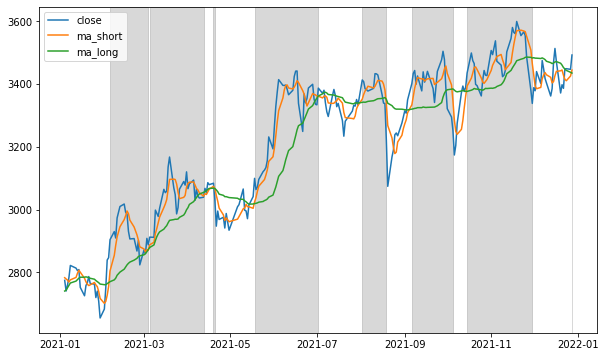

In [342]:
for file in FILE:
    # df_ = df_dummy.copy()
    name_ = file[43:].replace('.csv','')
    total_pr = 0
    trade_log_list = []
    # if name_=='KIKAI' or name_=='KAGAKU' or name_=='OROSIURI' or name_=='DENKIKIKI' or name_=='KOURI':
    # if name_=='KOUGYO' or name_=='SENI' or name_=='SYOKURYO' or name_=='RIKUUN' or name_=='GINKOU':
    for year in [2016,2017,2018,2019,2020,2021]:
        start_year = year
        end_year = year
        ts = TechnicalSimulation(hold_day=100)
        ts.simulate(file,path_daw,start_year=start_year,end_year=end_year,is_validate=True)
        df_tmp = ts.make_df_con(file,path_daw)
        trade_log = ts.trade_log
        
        price1 = df_tmp[df_tmp.index.year==year].mean()['close']
        price2 = ex_tpx_dict[year]

        alpha = price2/price1

        
        
        # df_.loc[1] += alpha * trade_log.loc[1]
        total_pr += alpha*trade_log['profit rate'].values[0]
        trade_log_list.append(alpha*trade_log['profit rate'].values[0])

    print("------------------")
    print(name_)
    output = ''
    for tr in trade_log_list:
        output += ('{:.2f}'.format(tr)+' & ')
        # break
    output += ('{:.2f}'.format(total_pr)+' \\\\')
    print(output)
    # print(total_pr)

        # print(year)
        # print(df_)
        
    trade_log_dict[file[43:].replace('.csv','')] = df_

# 業種別 Ustrategies つくる

In [532]:
uds_gyosyu_dict2 = {}
for file in FILE:
    name_ = file[43:].replace('.csv','')
    if name_=='KOUGYO' or name_=='SENI' or name_=='SYOKURYO' or name_=='RIKUUN' or name_=='GINKOU': 
        
        v_dic, lx_dic = make_value_lx_dict(path_=file)
        uds_dict, trade_dict, F_lis_dict = return_uds_dict(v_dic,lx_dic,width=20,stride=5,window_type='bla'\
            ,is_high_pass=False,is_low_pass=True,is_ceps=False,cut_off=3,order=4,path_=file,limit_year=2015)
        uds_gyosyu_dict2[name_] = uds_dict

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by ze

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by ze

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


In [570]:
trade_log_dict = {}
log_joui5_dict = {}
for file in FILE:
    # df_ = df_dummy.copy()
    name_ = file[43:].replace('.csv','')
    total_pr = 0
    trade_log_list = []
    
    profit_rate = 0
    # if name_=='KIKAI' or name_=='KAGAKU' or name_=='OROSIURI' or name_=='DENKIKIKI' or name_=='KOURI':
    if name_=='KOUGYO' or name_=='SENI' or name_=='SYOKURYO' or name_=='RIKUUN' or name_=='GINKOU':        
    # if not (name_=='KOUGYO' or name_=='SENI' or name_=='SYOKURYO' or name_=='RIKUUN' or name_=='GINKOU' \
    #     or name_=='KIKAI' or name_=='KAGAKU' or name_=='OROSIURI' or name_=='DENKIKIKI' or name_=='KOURI'):
        for year in [2017,2018,2019,2020,2021]:
            
            
            uds_dict = uds_gyosyu_dict_copy[name_]
            # uds_dict = uds_dict_copy[name_]
            
            uds = uds_dict[str(year)]
            df_tmp = uds.make_df_con(file,path_daw)
            price1 = df_tmp[df_tmp.index.year==year].mean()['close']
            price2 = ex_tpx_dict[year]
            alpha = price2/price1
            uds.simulate(file,path_daw,start_year=year,end_year=year,is_validate=True)
            log_joui5_dict[name_] = uds
            
            trade_log = uds.trade_log
            # total_profit += alpha*trade_log['total_profit'].values[0]
            # profit_rate = (total_profit/2500)*100
            profit_rate = alpha*trade_log['profit rate'].values[0]
            total_pr+= profit_rate
            trade_log_list.append([trade_log,uds.accuracy_df,uds.pr_log])
            
        # total_pr+= profit_rate
        # trade_log_list.append(profit_rate)
            
        # print("------------------")
        # print(name_)
        # output = ''
        # for tr in trade_log_list:
        #     output += ('{:.2f}'.format(tr)+' & ')
        #     # break
        # output += ('{:.2f}'.format(total_pr)+' \\\\')
        # print(output)
        trade_log_dict[name_] = trade_log_list

In [109]:
trade_log_dict

{'DENKIKIKI': [-0.17448291751182274,
  -16.79624220889183,
  14.348656807416102,
  16.795620790438917,
  -4.630284714410675],
 'KAGAKU': [9.498753114088117,
  2.294611107494498,
  13.434511383568227,
  9.081913017131653,
  3.372618597492178],
 'KIKAI': [8.884784790424375,
  0.787150685647102,
  10.599412949599266,
  8.507440364335705,
  -13.795423869776716],
 'KOURI': [7.665504062394835,
  -4.75986681317424,
  3.798906755879968,
  7.91564090415635,
  -2.6096973041929905],
 'OROSIURI': [8.115983435629749,
  -2.3836163019794334,
  8.289567576641891,
  0.8330659169147162,
  -13.675153405220954]}

In [114]:
import copy

uds_dict_copy = copy.deepcopy(uds_dict3)

In [115]:
for i,key in enumerate(uds_dict_copy):
    print(key)
    uds = uds_dict_copy[key]
    year = int(key)
    uds.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=True)
    print(uds.trade_log)
    

2011
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -86.0        -3.44           11        15.0       -29.0   

   mean_profit  cant_buy_count  
1    -7.818182               0  
2012
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         164.0         6.56           10        53.0       -19.0   

   mean_profit  cant_buy_count  
1         16.4               0  
2013
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         313.0        12.52           23       103.0       -51.0   

   mean_profit  cant_buy_count  
1    13.608696               0  
2014
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         149.0         5.96           16        60.0       -60.0   

   mean_profit  cant_buy_count  
1       9.3125               0  
2015
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         143.0         5.72           18        79.0      -197.0   

   mean_profit  

In [108]:
uds_dict['2015'].trade_log

total_profit  profit rate  trade_count  max_profit  min_profit  \
1         131.0         5.24           18        84.0       -55.0   

   mean_profit  cant_buy_count  
1     7.277778               0

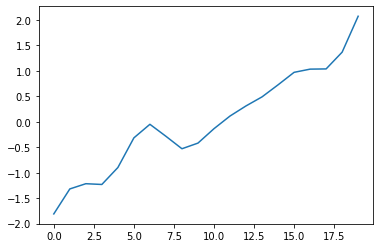

In [549]:
plt.plot(uds_dict['2017'].Ustrategies[0].spectrum)

# index 運用

In [91]:
df_dict, FILE = get_gyosyu_df()

In [51]:
ex_tpx_dict

{2016: 1390.704641350211,
 2017: 1671.4896265560167,
 2018: 1784.6612244897958,
 2019: 1651.6721991701245,
 2020: 1659.4628099173553,
 2021: 2032.320987654321}

------------------
GINKOU
1.86 & -8.81 & -4.62 & -0.32 & 11.77 & -0.12 \\
------------------
KOUGYO
9.30 & 2.72 & -3.85 & -3.76 & 13.73 & 18.13 \\
------------------
RIKUUN
2.98 & 2.24 & 3.10 & -0.75 & -2.73 & 4.84 \\


c:\Users\Owner\Desktop\program\Sotsuron\code\model\New_XGB\..\my_library\library.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.ax = plt.subplots(figsize=(10, 6))


------------------
SENI
6.82 & -10.88 & -1.63 & 5.48 & -0.97 & -1.18 \\
------------------
SYOKURYO
10.48 & -9.30 & 3.78 & -2.37 & -1.35 & 1.24 \\


<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

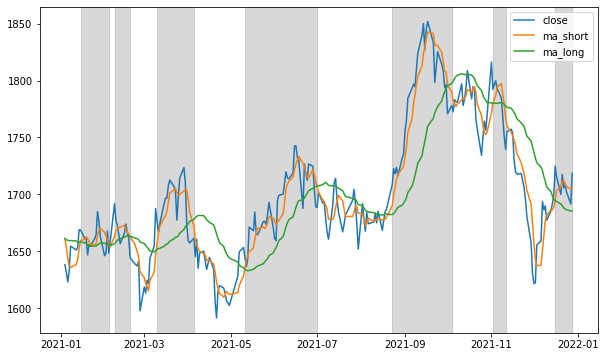

In [136]:
trade_log_dict_ts = {}
for file in FILE:
    # df_ = df_dummy.copy()
    name_ = file[43:].replace('.csv','')
    total_pr = 0
    trade_log_list = []
    profit_rate = 0
    if name_=='KOUGYO' or name_=='SENI' or name_=='SYOKURYO' or name_=='RIKUUN' or name_=='GINKOU':
    # if name_=='KIKAI' or name_=='KAGAKU' or name_=='OROSIURI' or name_=='DENKIKIKI' or name_=='KOURI':
    # if not (name_=='KOUGYO' or name_=='SENI' or name_=='SYOKURYO' or name_=='RIKUUN' or name_=='GINKOU' \
    #     or name_=='KIKAI' or name_=='KAGAKU' or name_=='OROSIURI' or name_=='DENKIKIKI' or name_=='KOURI'):
        for year in [2017,2018,2019,2020,2021]:
            # uds_dict = uds_gyosyu_dict[name_]
            # uds = uds_dict[str(year)]
            ts = TechnicalSimulation(hold_day=100)
            df_tmp = ts.make_df_con(file,path_daw)
            price1 = df_tmp[df_tmp.index.year==year].mean()['close']
            # df_tmp2 = ts.make_df_con(path_tpx,path_daw)
            price2 = ex_tpx_dict[year]
            alpha = price2/price1
            
            
            ts.simulate(file,path_daw,start_year=year,end_year=year,is_validate=True)
            trade_log = ts.trade_log
            # total_profit += alpha*trade_log['total_profit'].values[0]
            # profit_rate = (total_profit/2500)*100
            profit_rate = alpha*trade_log['profit rate'].values[0]
            total_pr+= profit_rate
            trade_log_list.append(profit_rate)
            
            # total_pr+= profit_rate
            # trade_log_list.append(profit_rate)
            
        print("------------------")
        print(name_)
        output = ''
        for tr in trade_log_list:
            output += ('{:.2f}'.format(tr)+' & ')
            # break
        output += ('{:.2f}'.format(total_pr)+' \\\\')
        print(output)
        trade_log_dict_ts[name_] = trade_log_list

DENKIKIKI


<Figure size 432x288 with 0 Axes>

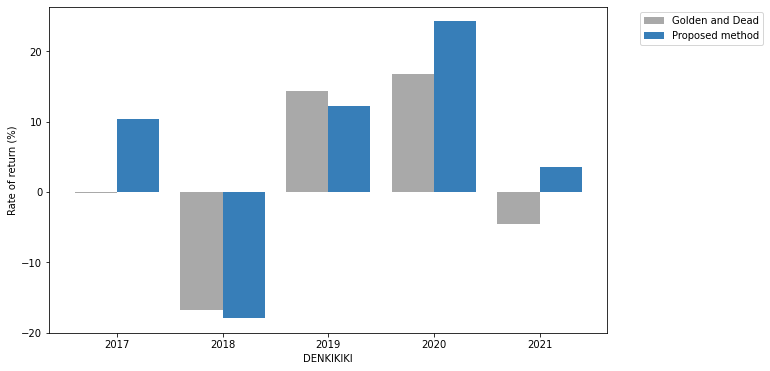

KAGAKU


<Figure size 432x288 with 0 Axes>

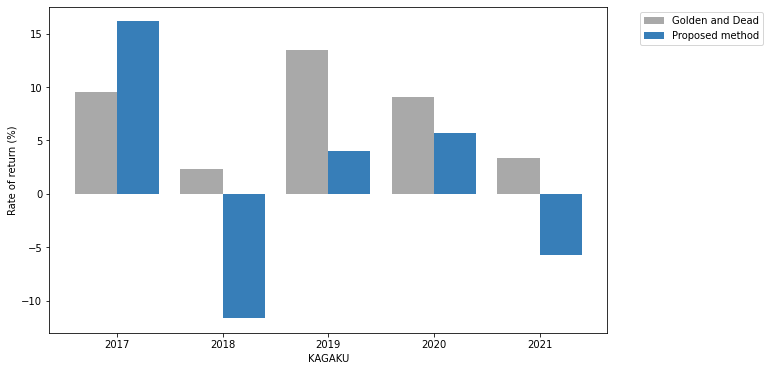

KIKAI


<Figure size 432x288 with 0 Axes>

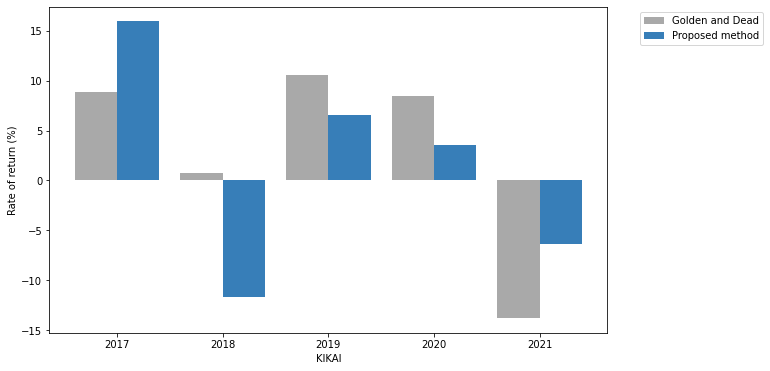

KOURI


<Figure size 432x288 with 0 Axes>

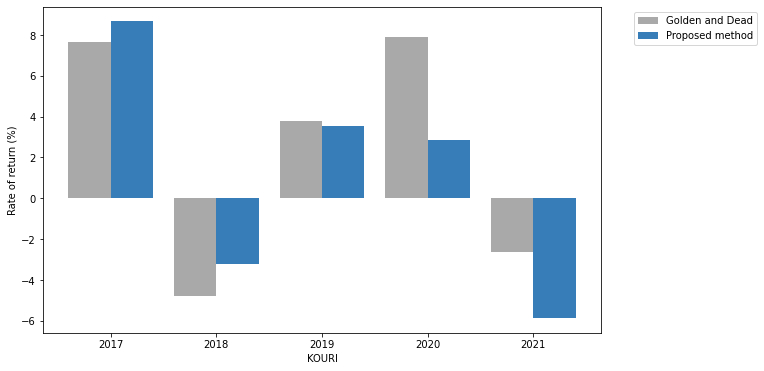

OROSIURI


<Figure size 432x288 with 0 Axes>

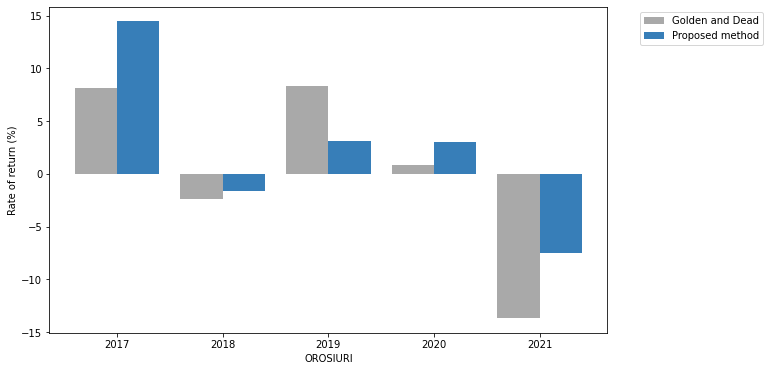

In [108]:
for i,key in enumerate(trade_log_dict):
    print(key)
    pr_list_ts = trade_log_dict[key]
    pr_list = trade_log_dict_ts[key]
    try:
        plot_var(pr_list_ts,pr_list,key)
    except Exception as e:
        print(e)
        print("---------")

In [480]:
pr_list[:0]

[]

In [510]:
cumulative_pr_list

[3.2399999999999998,
 15.88,
 14.920000000000002,
 20.160000000000004,
 21.960000000000004,
 21.720000000000006,
 13.280000000000006,
 18.200000000000006,
 28.360000000000007,
 30.340000000000007]

<Figure size 432x288 with 0 Axes>

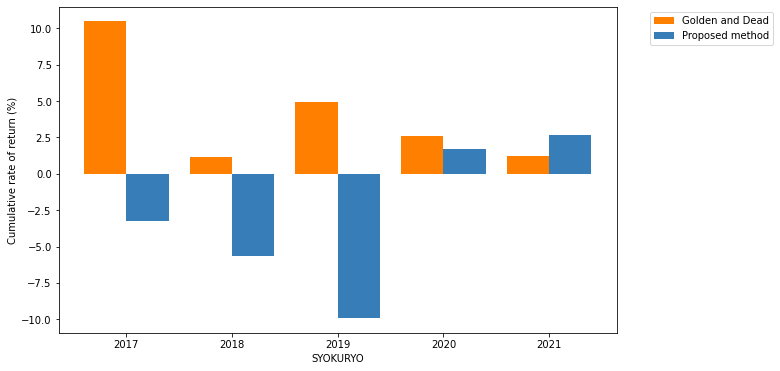

In [577]:
plot_cumulative_var(cumulative_list,cumulative_list_ts,key)

In [138]:
trade_log_dict ={}
trade_log_dict['GINKOU'] = [5.67 , -10.96 , -0.67 , 6.67 , 0.50]
trade_log_dict['KOUGYO'] = [20.86 , -14.85 , 25.04 , -5.97 , 30.24]
trade_log_dict['RIKUUN'] = [1.73 , -4.41 , -6.77 , 3.53 , 5.97]
trade_log_dict['SENI'] = [3.13 , -4.47 , -3.74 , 5.85 , 12.55 ]
trade_log_dict['SYOKURYO'] = [-3.25 , -2.38 , -4.29 , 11.65 , 0.94]

GINKOU


<Figure size 432x288 with 0 Axes>

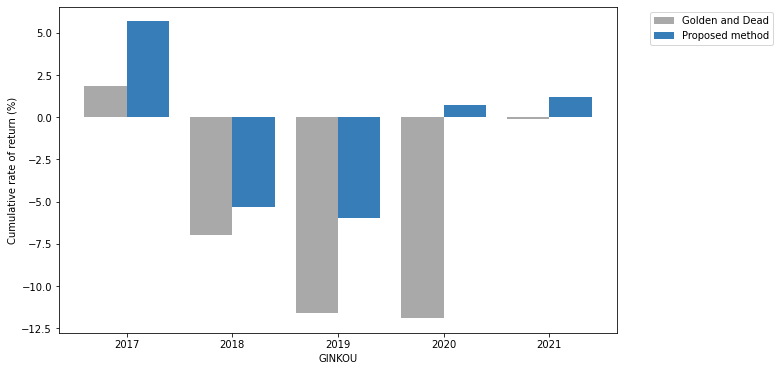

KOUGYO


<Figure size 432x288 with 0 Axes>

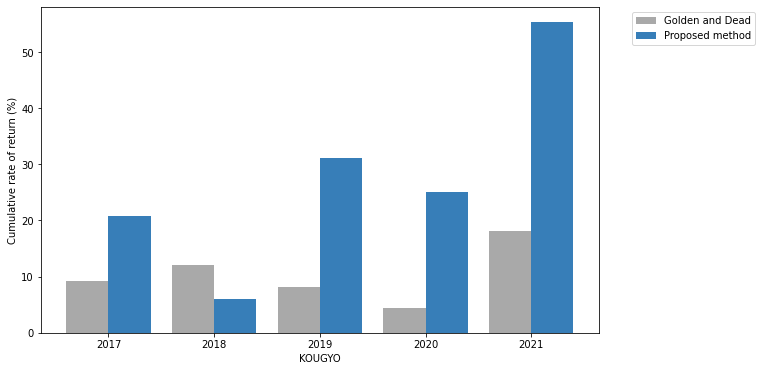

RIKUUN


<Figure size 432x288 with 0 Axes>

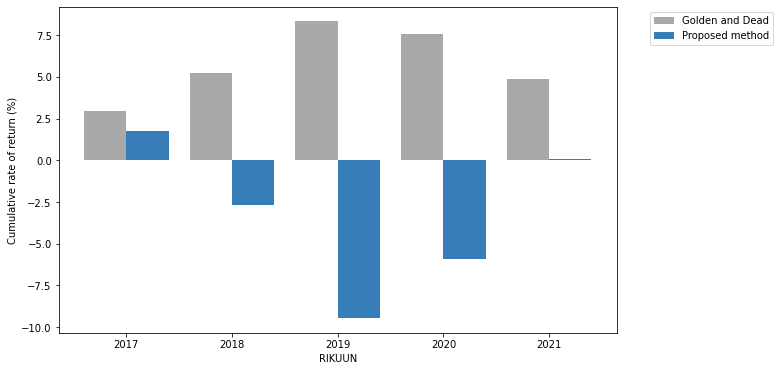

SENI


<Figure size 432x288 with 0 Axes>

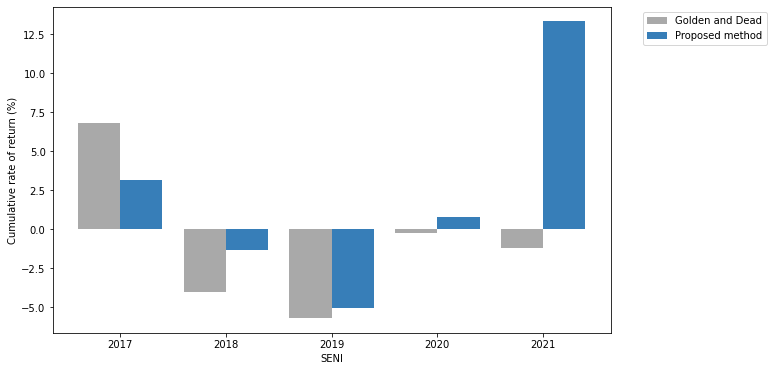

SYOKURYO


<Figure size 432x288 with 0 Axes>

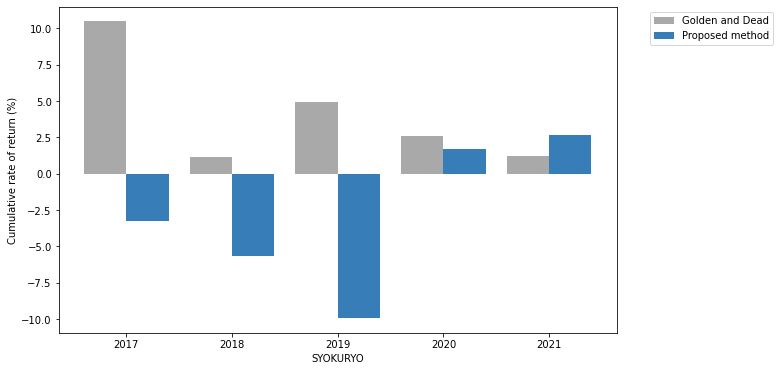

In [139]:
for i,key in enumerate(trade_log_dict):
    print(key)
    pr_list_ts = trade_log_dict[key]
    pr_list = trade_log_dict_ts[key]

    cumulative_list = []
    for i in range(len(pr_list)):
        total_pr = sum(pr_list[:i+1])
        cumulative_list.append(total_pr)
        
    cumulative_list_ts = []
    for i in range(len(pr_list_ts)):
        total_pr = sum(pr_list_ts[:i+1])
        cumulative_list_ts.append(total_pr)
        
    plot_cumulative_var(cumulative_list,cumulative_list_ts,key)
        

In [144]:
sum(pr_list)

30.340000000000007

<Figure size 432x288 with 0 Axes>

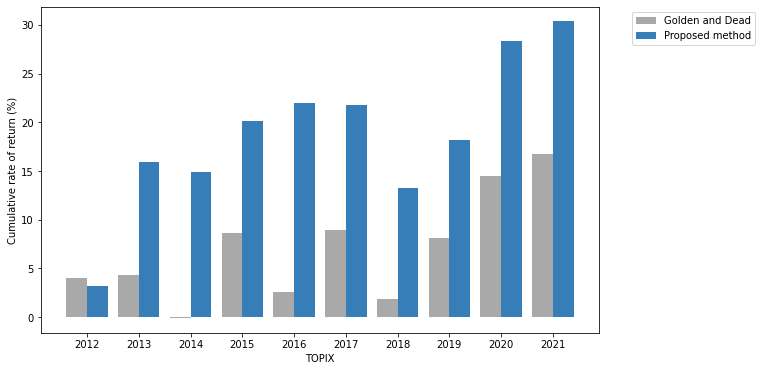

In [146]:
pr_list = [3.24 , 12.64 , -0.96 , 5.24 , 1.80 , -0.24 , -8.44 , 4.92 , 10.16 , 1.98 ]
pr_list_ts = [4.00 , 0.36 , -4.44 , 8.68 , -6.04  , 6.36 , -7.04 , 6.20 , 6.40 , 2.26]

cumulative_list = []
for i in range(len(pr_list)):
    total_pr = sum(pr_list[:i+1])
    cumulative_list.append(total_pr)
    
cumulative_list_ts = []
for i in range(len(pr_list_ts)):
    total_pr = sum(pr_list_ts[:i+1])
    cumulative_list_ts.append(total_pr)
    
plot_cumulative_var(cumulative_list_ts,cumulative_list,'TOPIX')

# pr_list

In [139]:
pr_list = [15.94 , -11.73 , 6.56 , 3.57 , -6.35 ,1.60 , 9.75]


print(len(pr_list))

print(np.mean(pr_list))
print(np.std(pr_list))

7
2.762857142857143
8.717522115643566


In [39]:
mean_ = np.mean(pr_list)
std_ = 0
for pr in pr_list:
    std_ += (pr-mean_)**2
    
std_ /= len(pr_list)
std_**(0.5)

5.423681775325687